<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantumsensing_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for Single-Copy Photon Localization in Quantum Sensing**

* **Quadratic Unitary Models:** Excel at low photon counts (often exceeding theoretical quantum advantage) and high noise levels, demonstrating better noise resilience and high efficiency in weak signal regimes.
* **Simpler Models (Linear & Classical):** Perform better at high photon counts and low noise levels, offering simpler implementation and lower computational cost in strong, clean signal conditions.
* **Physical Rationale:** Simpler models suffice for strong, clean signals where quantum advantage is less critical; complex quadratic unitary models are crucial for weak or noisy signals to leverage quantum effects and maintain physical plausibility.

##### <font color="blue">*Libraries and Hyperparameters*

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import time
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Set random seed for reproducibility
np.random.seed(42)

# Setup parameters
L = 1.0        # Length of the sensor array
d = 20         # Number of sensors
delta = L / d  # Sensor spacing
k = 5          # Wave number parameter
l = 0.3        # Cutoff length (exponential decay range)
alpha = 0.3    # Default noise level

# Sensor positions for all sensors
sensor_positions = np.linspace(0, L, d, endpoint=False)

# Number of samples to generate for main experiment to get accurate results
num_samples = 500

# Number of measurements for each density matrix in data generation with empirical density matrices
n_measurements = 20
n_pred_samples = 20

# Photon count analysis
photon_counts=[0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 1, 5, 10, 15, 20, 25, 50, 100, 200]
  # average photon count: 5   = Probability of detecting zero photons in any measurement is ~0.7%
  # average photon count: 0.5 = Probability of detecting zero photons in any measurement is ~60.7%
  # average photon count: 0.1 = Probability of detecting zero photons in any measurement is ~90%
avg_photons = 1 # default for when no specific value is given when calling functions


# Number of samples to generate for analyses functions to observe trends and reduce computational cost
num_samples_analyze_noise_impact = 10
num_samples_analyze_copies_impact = 10

# Number of statistical runs
n_runs = 20

##### <font color="blue">*Pure States, Density Matrix, and Vectorization*

In [28]:
# Create quantum pure state for source at position s with phase encoding based on distance between source and sensors
def create_pure_state(s):
    # Phase is proportional to physical distance. Wave number k determines spatial frequency
    phases = -2 * np.pi * k * (s - sensor_positions)

    # Apply cutoff effect where signal decays with distance
    cutoff_factor = np.exp(-np.abs(s - sensor_positions) / l)

    # Normalize and create state vector with proper phases
    amplitudes = cutoff_factor / np.sqrt(np.sum(cutoff_factor**2))
    state = amplitudes * np.exp(1j * phases)

    return state

# Create density matrix with noise level alpha (default)
def create_density_matrix(state, alpha):
    # Pure state density matrix
    rho_pure = np.outer(state, np.conjugate(state))

    # Add noise (mixing with maximally mixed state)
    rho = (1 - alpha) * rho_pure + alpha * np.eye(d) / d

    return rho

# Create empirical density matrix from measurements with option for low photon count simulation
def create_empirical_density_matrix(state, alpha, n_samples, low_photon=False, avg_photons=avg_photons):
    d = len(state)

    # Theoretical reference matrices
    rho_pure = np.outer(state, np.conjugate(state))
    rho_mixed = np.eye(d) / d

    # Initialize counts for tomography
    empirical_counts = np.zeros((d, d), dtype=complex)

    # Track actual measurements (important for low photon regime)
    actual_measurements = 0

    # Generate measurements
    for _ in range(n_samples):
        # For low photon simulation, determine if any photons are detected
        if low_photon:
            photon_count = np.random.poisson(avg_photons)
            if photon_count == 0:
                # No photons detected, no information gained
                continue
            # We have at least one photon
            actual_measurements += 1
        else:
            # Normal mode (not low photon)
            photon_count = 1  # Just to avoid errors in noise_level calculation
            actual_measurements += 1

        # Decide if sampling from noise or signal
        if np.random.rand() < alpha:
            # Sample from maximally mixed state (noise component)
            outcome = np.random.randint(0, d)
            basis_state = np.zeros(d, dtype=complex)
            basis_state[outcome] = 1.0
            proj = np.outer(basis_state, np.conjugate(basis_state))
        else:
            # Sample from pure state according to Born rule
            probabilities = np.abs(state)**2

            # Add shot noise if in low photon mode
            if low_photon and photon_count > 0:
                # Shot noise scales as 1/√N for N photons (quantum limit)
                noise_level = 1.0 / np.sqrt(photon_count)
                probabilities_noisy = probabilities + noise_level * np.random.randn(len(probabilities))
                probabilities_noisy = np.abs(probabilities_noisy)  # Ensure non-negative
                probabilities_noisy = probabilities_noisy / np.sum(probabilities_noisy)  # Normalize
                probabilities = probabilities_noisy

            # Sample according to (possibly noisy) probabilities
            outcome = np.random.choice(d, p=probabilities)
            basis_state = np.zeros(d, dtype=complex)
            basis_state[outcome] = 1.0
            proj = np.outer(basis_state, np.conjugate(basis_state))

        # Add to counts
        empirical_counts += proj

    # If no actual measurements were performed, return a maximally mixed state
    if actual_measurements == 0:
        return np.eye(d) / d

    # Normalize by actual measurement count
    rho_empirical = empirical_counts / actual_measurements

    # Ensure the matrix is Hermitian (physical)
    rho_empirical = (rho_empirical + np.conjugate(rho_empirical.T)) / 2

    # Ensure trace 1 (physical)
    trace = np.trace(rho_empirical)
    if trace > 0:
        rho_empirical = rho_empirical / trace

    return rho_empirical

def vectorize_density_matrix(rho):
    # Convert density matrix to feature vector for ML
    # Extract real and imaginary parts and concatenate
    vec_real = np.real(rho).flatten()
    vec_imag = np.imag(rho).flatten()
    return np.concatenate((vec_real, vec_imag))

def get_classical_info(rho):
    # Extract classical information (diagonal elements)
    return np.real(np.diag(rho))

Photon from source position s interacts with sensor array, quantum state is:

> $|\psi(s)\rangle = \sum_{j=0}^{d-1} \phi_j(s) |j\rangle$

with $|j\rangle$ being basis state to $j$-th sensor detecting the photon, and $\phi_j(s)$ the probability amplitude for detection at sensor $j$.

Quantum state $|\psi(s)\rangle$ is built from phases calculated for each sensor based on the source position, cutoff distance applied, amplitudes normalized (to get a valid quantum state), combine amplitudes and phases for the final compex-valued state vector. Each array element corresponds to $\psi_j(s)$ for sensor j.

*Nota bene: the phase encoding part relates the source position s to the phase of the quantum state at each sensor position:*

> $\phi_j(s) = \frac{1}{\sqrt{d}} \exp\left(-i \frac{2\pi k}{d}(s - j\delta)\right)$

k is wave number, $(s - j\delta)$ is distance between source and sensor $j$ computed by `(s - sensor_positions)`:

```
phases = -2 * np.pi * k * (s - sensor_positions) / d
```



**Density Matrix Formation**

Pure state density matrix is:

> $\rho_{pure} = |\psi(s)\rangle\langle\psi(s)|$

implemented as `rho_pure = np.outer(state, np.conjugate(state))`

Noisy density matrix with noise parameter $\alpha \in [0,1]$ is:

> $\rho = (1-\alpha)|\psi(s)\rangle\langle\psi(s)| + \alpha\frac{I}{d}$

- $(1-\alpha)$ is the fraction of the pure state preserved
- $\alpha\frac{I}{d}$ is uniform mixing (here white noise)
- $I$ is identity

Noise model is implemented by mixing with maximally mixed state: $\frac{I}{d}$ as `rho = (1 - alpha) * rho_pure + alpha * np.eye(d) / d`, using a **depolarizing noise model**, where with probability $\alpha$, the pure state is replaced by a completely mixed state $\frac{I}{d}$.

Quantum information is extracted with `vectorize_density_matrix`, including phase relationships from off-diagonal elements. Classical information (detection probabilities) is in diagonal elements of the density matrix $\rho_jj = (1- \alpha)|\phi_j(s)|^2 + \alpha(\frac{1}{d}) $ and is extracted from diagonal elements with `get_classical_info`.

***Phase Differences and Localization***

The phase difference between two sensors next to each other $j$ and $j+1$ is

> $\Delta \phi_{j,j+1}(s) = \arg(\phi_{j+1}(s)) - \arg(\phi_j(s)) = \frac{2\pi k\delta}{d}$

This constant phase difference encodes information about the source location. For any two sensors $j$ and $m$

> $\Delta \phi_{j,m}(s) = \frac{2\pi k\delta}{d}(m-j)$

the total phase accumulated across the array follows a linear relationship with the source position. This allows the localization.

- The quantum state `state = amplitudes * np.exp(1j * phases)` contains the phase information (each element has a phase that depends on the source position)
   ```python
   phases = -2 * np.pi * k * (s - sensor_positions) / d
   state = amplitudes * np.exp(1j * phases)
   ```
- The density matrix `rho` preserves this phase information in its off-diagonal elements. The vectorized density matrix retains phase relationships.
- The ML models can discover the patterns during training (which aspects of phase information are most useful for localization?), which quantifies quantum advantage

##### <font color="blue">*Data Generation*

In [31]:
# Unified generate_dataset function replacing the three previous functions
def generate_dataset(num_samples, alpha, quantum=True, use_empirical_rho=False,
                     low_photon=False, n_measurements=n_measurements, avg_photons=avg_photons):
    X, y = [], []

    for _ in range(num_samples):
        # Random source location
        s = np.random.rand() * L

        # Create quantum state
        state = create_pure_state(s)

        # Create appropriate density matrix based on parameters
        if use_empirical_rho:
            # Use the unified empirical density matrix function with appropriate parameters
            rho = create_empirical_density_matrix(
                state, alpha, n_measurements,
                low_photon=low_photon,
                avg_photons=avg_photons
            )
        else:
            # Use theoretical density matrix
            rho = create_density_matrix(state, alpha)

        # Extract features (quantum or classical)
        if quantum:
            features = vectorize_density_matrix(rho)
        else:
            features = get_classical_info(rho)

        X.append(features)
        y.append(s)

    return np.array(X), np.array(y)

(Jarrod)

1. I was brainstorming briefly about how to add finite sampling in an easy but somewhat predictive way, and think perhaps an easy way to get basic effects at least in the maximum potential for the state is
  * (a) for the prediction step, replace the density matrix with an empirical density matrix defined by a finite number of samples, and do it independently for each "copy" in the density matrix.  That is, we have some number of samples n_s, and we draw the correct state with the same probability related to alpha and the totally mixed state with probability related to alpha, but now they needn't match up.
  * (b) Sample an average in the output according to number of samples. In a multi-class classification setup for prediction, this probably means take repeated samples according to n_s from the final probability distribution, then take an average or majority vote.  For regression prediction, I guess this means include the uncertainty in your model parameters and take n_s draws from different draws of the model (not sure if there is a built in function for this vs having to add gaussian noise to the model manually) then take the average or majority vote.

2. For linear models, it would be interesting to compare the quality of solution after unitary projection in the same way, to make sure we're not cheating.  That is, if we get some model defined by a matrix A, do an SVD and use UV to find the closest unitary model, and report results on that.  Not sure how to most easily do this in other types of models, but it's an interesting baseline!


##### <font color="blue">*Calculate statistics*

In [34]:
# Calculate mean, standard deviation and confidence intervals for a list of values
def calculate_stats(values, confidence=0.95):
    mean = np.mean(values)
    std_dev = np.std(values, ddof=1)  # Sample standard deviation

    # Calculate confidence interval
    n = len(values)
    sem = std_dev / np.sqrt(n)  # Standard error of mean
    h = sem * stats.t.ppf((1 + confidence) / 2, n - 1)  # Margin of error

    return mean, std_dev, h

# Perform t-tests to compare different models and return p-values
def perform_t_tests(results_dict):
    p_values = {}

    # Compare quantum linear vs. quantum quadratic
    p_values['q_linear_vs_q_quad'] = stats.ttest_ind(
        results_dict['rmse_linear_q_all'],
        results_dict['rmse_quad_q_all']
    ).pvalue

    # Compare classical linear vs. classical quadratic
    p_values['c_linear_vs_c_quad'] = stats.ttest_ind(
        results_dict['rmse_linear_c_all'],
        results_dict['rmse_quad_c_all']
    ).pvalue

    # Compare quantum linear vs. classical linear
    p_values['q_linear_vs_c_linear'] = stats.ttest_ind(
        results_dict['rmse_linear_q_all'],
        results_dict['rmse_linear_c_all']
    ).pvalue

    # Compare quantum quadratic vs. classical quadratic
    p_values['q_quad_vs_c_quad'] = stats.ttest_ind(
        results_dict['rmse_quad_q_all'],
        results_dict['rmse_quad_c_all']
    ).pvalue

    return p_values

##### <font color="blue">*Simulation 1: Quantum state sanity check*

*(Jarrod) For the visualization in this case, we'd have to use the diagonals of the density matrix, but that will also be instructive I think to see what the "signals" look like in real space to guess a potential related mechanism*

State visualization for sanity check
Quantum states with corrected phase encoding


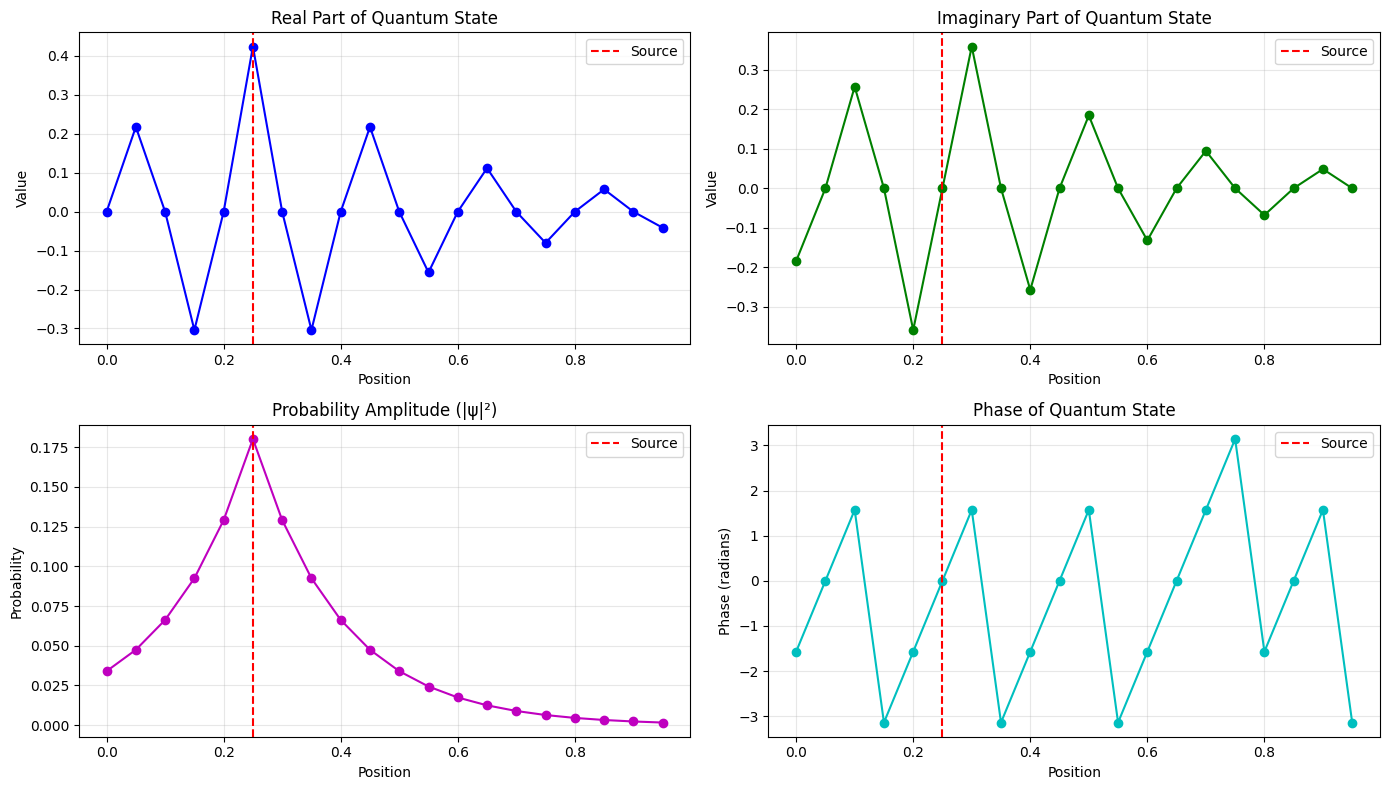

Wave number parameter k = 5
Corresponding wavelength = 0.2000
Array length L = 1.0
Number of wavelengths in array = 5.00


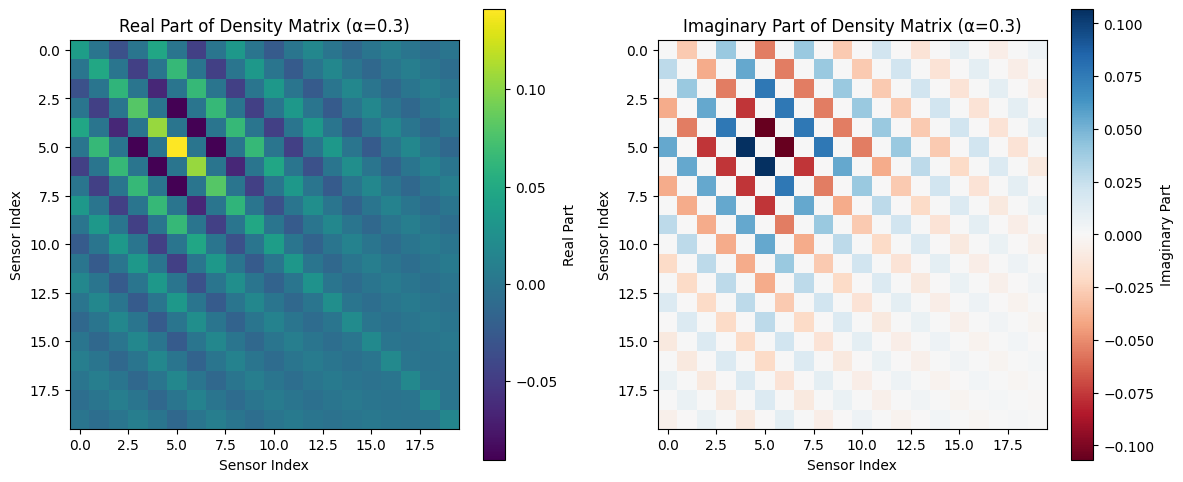

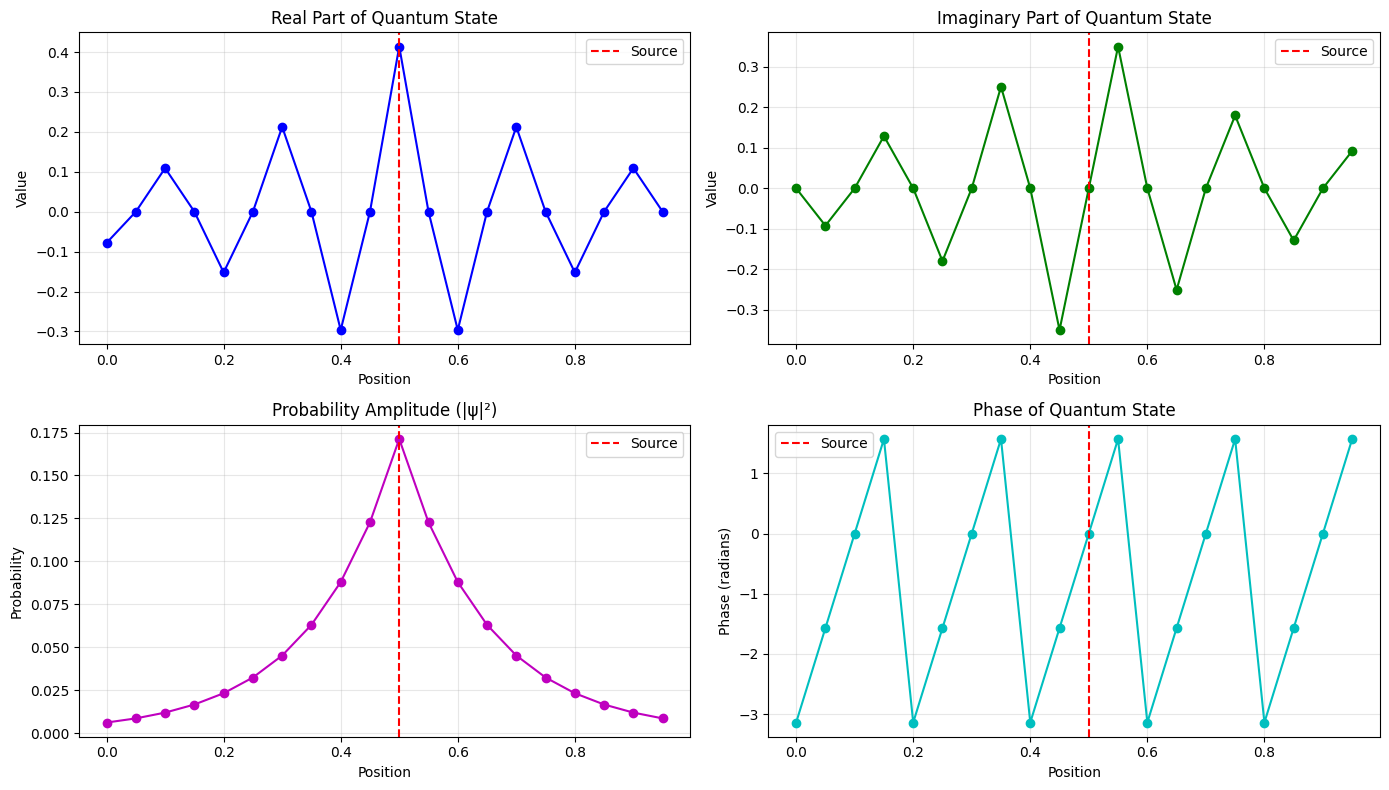

Wave number parameter k = 5
Corresponding wavelength = 0.2000
Array length L = 1.0
Number of wavelengths in array = 5.00


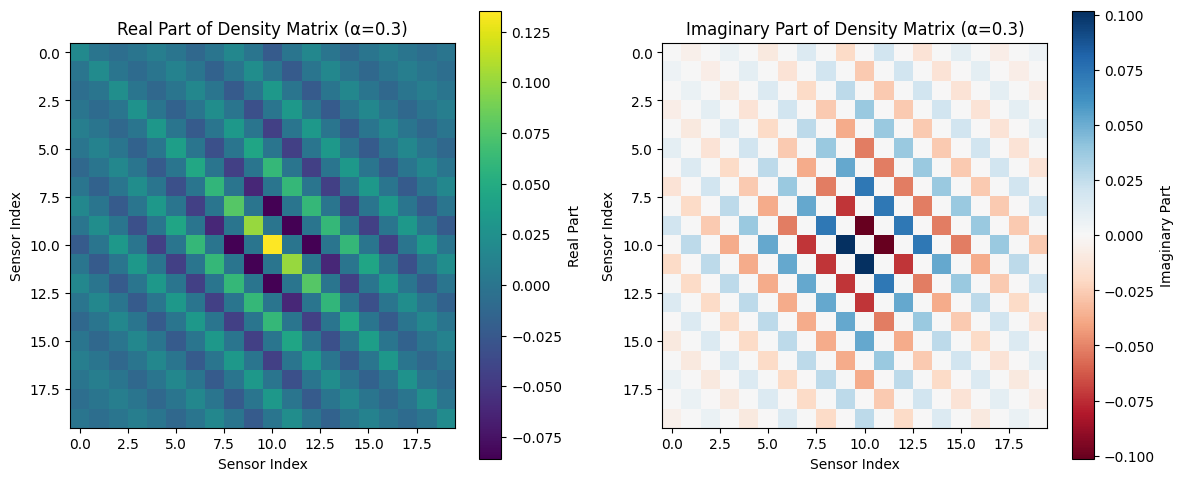

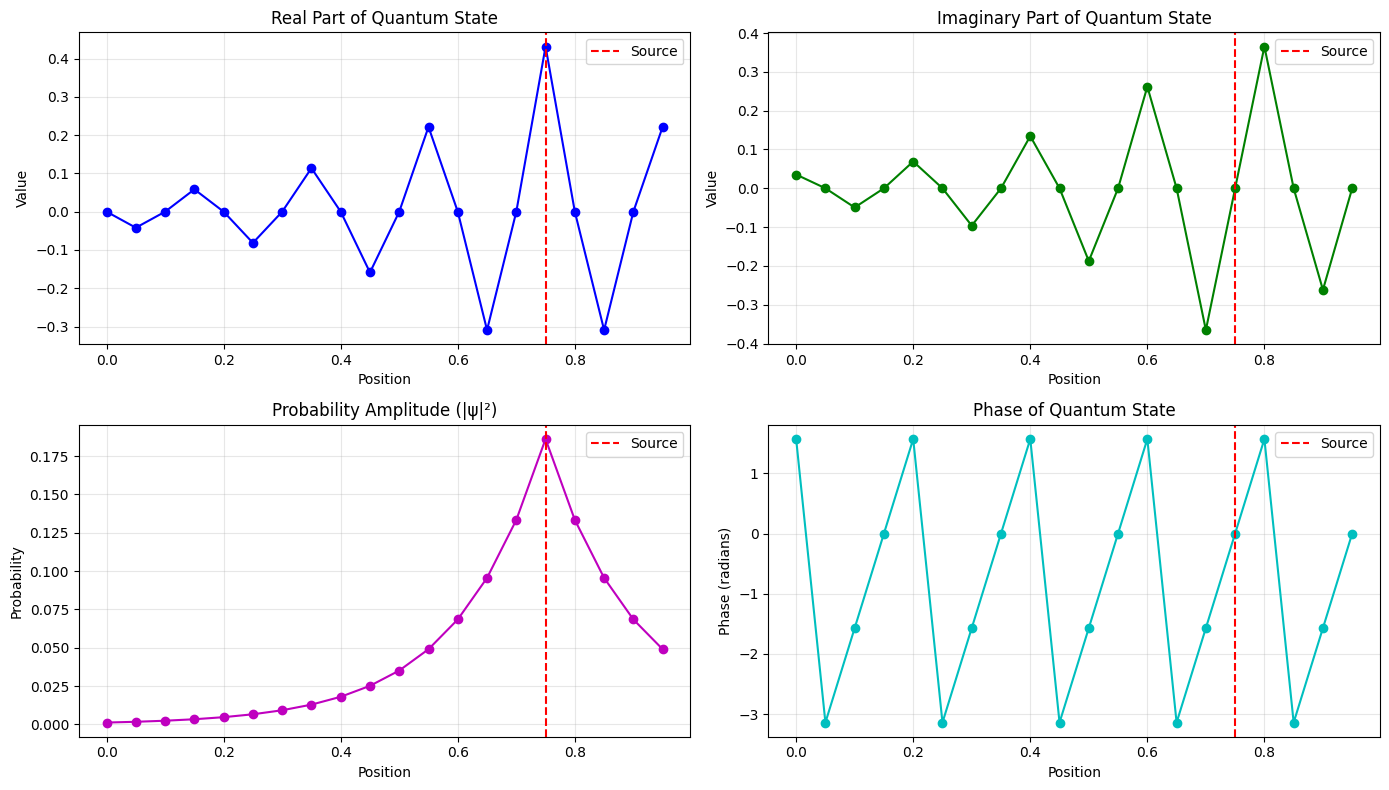

Wave number parameter k = 5
Corresponding wavelength = 0.2000
Array length L = 1.0
Number of wavelengths in array = 5.00


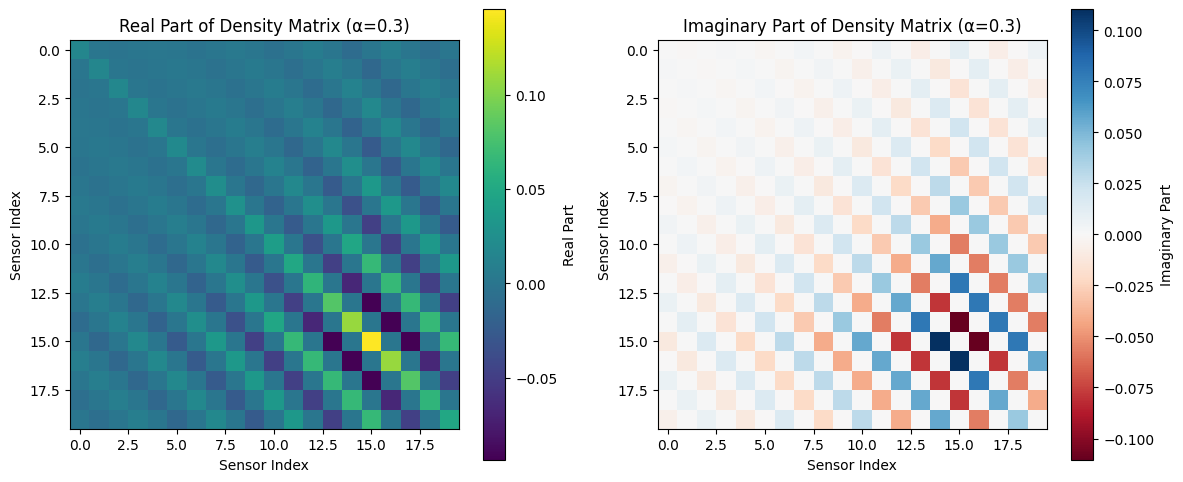

In [32]:
# Visualize the quantum state for a given source position
def plot_quantum_state(s, alpha=alpha):
    # Create the quantum state
    state = create_pure_state(s)

    # Extract real and imaginary parts and amplitude
    real_part = np.real(state)
    imag_part = np.imag(state)
    amplitude = np.abs(state)**2
    phase = np.angle(state)

    # Create plots for quantum state
    plt.figure(figsize=(14, 8))

    # Plot real part
    plt.subplot(2, 2, 1)
    plt.plot(sensor_positions, real_part, 'b-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Real Part of Quantum State')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot imaginary part
    plt.subplot(2, 2, 2)
    plt.plot(sensor_positions, imag_part, 'g-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Imaginary Part of Quantum State')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot amplitude (probability)
    plt.subplot(2, 2, 3)
    plt.plot(sensor_positions, amplitude, 'm-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Probability Amplitude (|ψ|²)')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot phase
    plt.subplot(2, 2, 4)
    plt.plot(sensor_positions, phase, 'c-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Phase of Quantum State')
    plt.xlabel('Position')
    plt.ylabel('Phase (radians)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print wavelength information for sanity check
    wavelength = 1 / k
    print(f"Wave number parameter k = {k}")
    print(f"Corresponding wavelength = {wavelength:.4f}")
    print(f"Array length L = {L}")
    print(f"Number of wavelengths in array = {L/wavelength:.2f}")

    # Create density matrix with noise
    rho = create_density_matrix(state, alpha)

    # Create a new figure for density matrix visualization
    plt.figure(figsize=(12, 5))

    # Plot real part of density matrix
    plt.subplot(1, 2, 1)
    plt.imshow(np.real(rho), cmap='viridis')
    plt.colorbar(label='Real Part')
    plt.title(f'Real Part of Density Matrix (α={alpha})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Sensor Index')

    # Plot imaginary part of density matrix
    plt.subplot(1, 2, 2)
    plt.imshow(np.imag(rho), cmap='RdBu')
    plt.colorbar(label='Imaginary Part')
    plt.title(f'Imaginary Part of Density Matrix (α={alpha})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Sensor Index')

    plt.tight_layout()
    plt.show()

# Run with different source positions for sanity check
def run_state_visualization():
    print("Quantum states with corrected phase encoding")

    # Test with source at different positions
    plot_quantum_state(0.25)
    plot_quantum_state(0.5)
    plot_quantum_state(0.75)

# State visualization to verify phase encoding (sanity check)
if __name__ == "__main__":

    print("State visualization for sanity check")
    run_state_visualization()

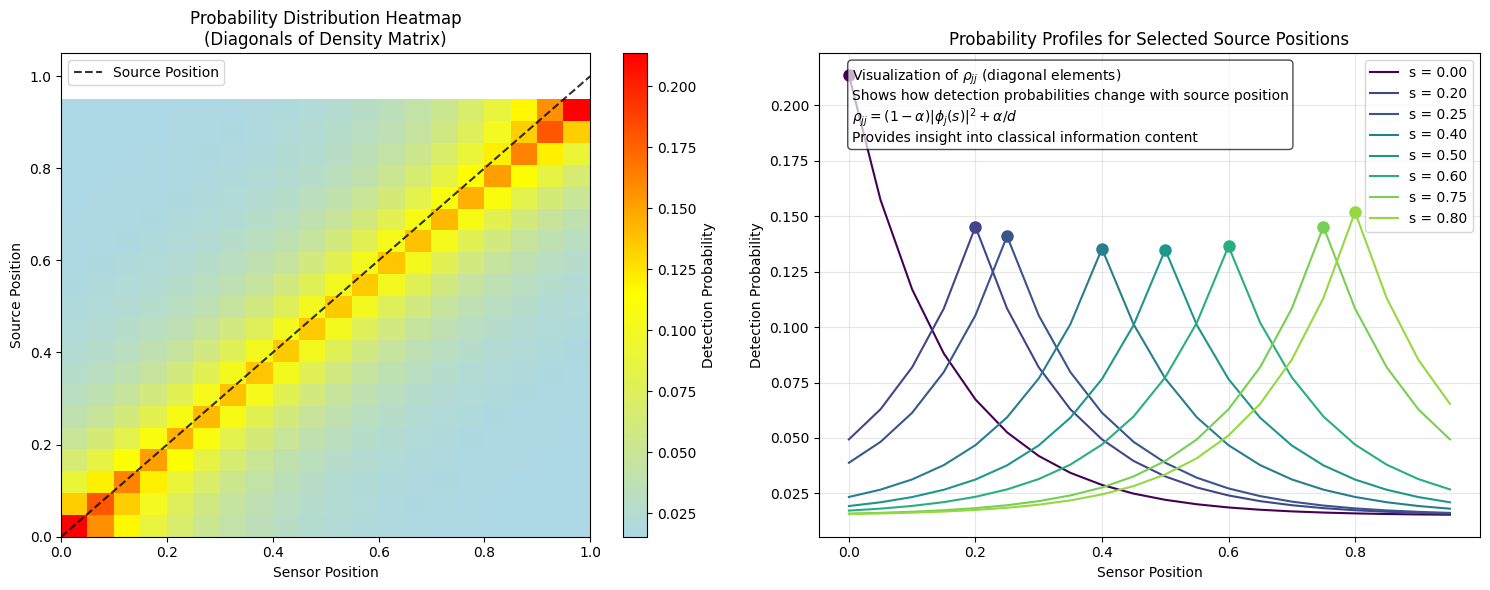

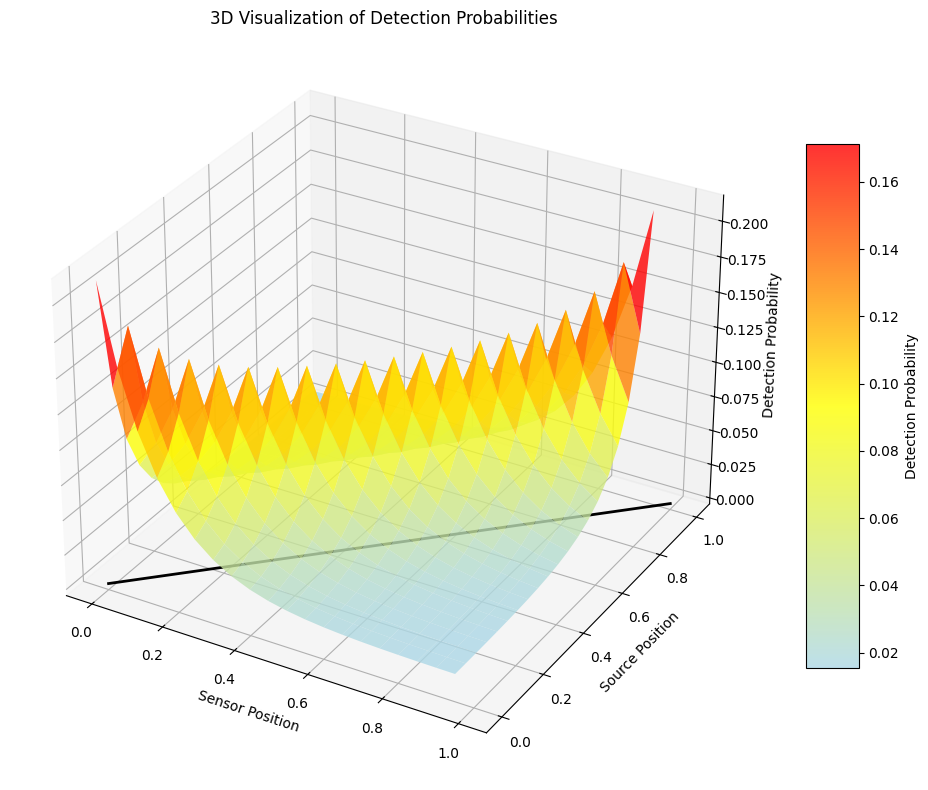

In [33]:
# Visualize how the diagonals of the density matrix (detection probabilities) change with different source positions
def visualize_density_matrix_diagonals(source_positions, L=L, d=d, k=k, l=l, alpha=alpha):

    # Sensor positions
    sensor_positions = np.linspace(0, L, d, endpoint=False)

    # Create figure with two subplots (heatmap and selected profiles)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Matrix to store diagonals for heatmap
    probability_matrix = np.zeros((len(source_positions), d))

    # Colors for different source positions in line plot
    colors = plt.cm.viridis(np.linspace(0, 1, len(source_positions)))

    # Calculate probability distributions for each source position
    for i, s in enumerate(source_positions):
        # Create pure state for source at position s
        phases = -2 * np.pi * k * (s - sensor_positions)
        cutoff_factor = np.exp(-np.abs(s - sensor_positions) / l)
        normalization = np.sqrt(np.sum(cutoff_factor**2))
        amplitudes = cutoff_factor / normalization
        state = amplitudes * np.exp(1j * phases)

        # Create density matrix with noise
        rho_pure = np.outer(state, np.conjugate(state))
        rho = (1 - alpha) * rho_pure + alpha * np.eye(d) / d

        # Extract diagonal elements (detection probabilities)
        probabilities = np.real(np.diag(rho))
        probability_matrix[i] = probabilities

        # Plot probability distribution for selected source positions
        # Plot a few to avoid cluttering
        if i % (len(source_positions) // 5) == 0 or s in [0.25, 0.5, 0.75]:
            ax2.plot(sensor_positions, probabilities, '-', color=colors[i],
                     label=f's = {s:.2f}')

            # Add marker for the actual source position
            idx = np.abs(sensor_positions - s).argmin()  # Find closest sensor
            ax2.plot(s, probabilities[idx], 'o', color=colors[i], markersize=8)

    # Create custom colormap that highlights variations better
    colors_custom = [(0, 'lightblue'), (0.5, 'yellow'), (1, 'red')]
    custom_cmap = LinearSegmentedColormap.from_list('custom_divergent', colors_custom)

    # Plot heatmap of probability distributions
    im = ax1.imshow(probability_matrix, aspect='auto', origin='lower', cmap=custom_cmap,
                   extent=[0, L, source_positions[0], source_positions[-1]])

    # Add diagonal line showing where source position equals sensor position
    ax1.plot([0, L], [0, L], 'k--', alpha=0.8, label='Source Position')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label('Detection Probability')

    # Customize heatmap
    ax1.set_xlabel('Sensor Position')
    ax1.set_ylabel('Source Position')
    ax1.set_title('Probability Distribution Heatmap\n(Diagonals of Density Matrix)')
    ax1.legend(loc='upper left')

    # Customize line plot
    ax2.set_xlabel('Sensor Position')
    ax2.set_ylabel('Detection Probability')
    ax2.set_title('Probability Profiles for Selected Source Positions')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Add annotations explaining the visualization
    textstr = '\n'.join([
        r'Visualization of $\rho_{jj}$ (diagonal elements)',
        r'Shows how detection probabilities change with source position',
        r'$\rho_{jj} = (1-\alpha)|\phi_j(s)|^2 + \alpha/d$',
        r'Provides insight into classical information content'
    ])

    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax2.text(0.05, 0.97, textstr, transform=ax2.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

    # Create additional visualization: 3D surface plot
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create meshgrid for surface plot
    X, Y = np.meshgrid(sensor_positions, source_positions)

    # Plot surface
    surf = ax.plot_surface(X, Y, probability_matrix, cmap=custom_cmap,
                          linewidth=0, antialiased=True, alpha=0.8)

    # Add colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=10)
    cbar.set_label('Detection Probability')

    # Add diagonal line showing where source position equals sensor position
    ax.plot([0, L], [0, L], [0, 0], 'k-', linewidth=2, label='Source Position Line')

    # Customize 3D plot
    ax.set_xlabel('Sensor Position')
    ax.set_ylabel('Source Position')
    ax.set_zlabel('Detection Probability')
    ax.set_title('3D Visualization of Detection Probabilities')

    plt.tight_layout()
    plt.show()

# Visualize how the diagonals of the density matrix (detection probabilities) change with different source positions
L = 1.0        # Length of the sensor array
d = 20         # Number of sensors
delta = L / d  # Sensor spacing
k = 5          # Wave number parameter
l = 0.3        # Cutoff length (exponential decay range)
alpha = 0.3    # Default noise level
sensor_positions = np.linspace(0, L, d, endpoint=False)
visualize_density_matrix_diagonals(sensor_positions)

##### <font color="blue">*Simulation 2: Linear and quadratic models (ideal conditions and with finite sampling and unitary projection)*

Based on the code you've shared, there are several types of data being used in the experiments:

1. **Ideal Quantum Data**: Generated using theoretical density matrices without empirical sampling effects.
   - Created when `generate_dataset` is called with `quantum=True` and `use_empirical_rho=False`
   - Represents a "perfect" quantum system without measurement limitations

2. **Ideal Classical Data**: Classical data (likely diagonal-only matrices) without sampling effects.
   - Created when `generate_dataset` is called with `quantum=False` and `use_empirical_rho=False`
   - Used as a baseline comparison

3. **Finite-Sampled Quantum Data**: Quantum data with realistic measurement limitations.
   - Created when `generate_dataset` is called with `quantum=True` and `use_empirical_rho=True`
   - Includes `n_measurements` parameter to control how many measurements are used to reconstruct the density matrix
   - Represents realistic quantum data collection with statistical uncertainty

4. **Finite-Sampled Classical Data**: Classical data with measurement limitations.
   - Created when `generate_dataset` is called with `quantum=False` and `use_empirical_rho=True`

Then, several different modeling approaches are applied to these datasets:

- Linear regression (degree=1)
- Quadratic regression (degree=2)
- Unitary-projected linear models
- Unitary-projected quadratic models
- Models with sampling-based prediction (adding noise during prediction)

The unitary projection doesn't create new data - rather, it transforms the model's parameters to respect quantum mechanical constraints. The projection is applied to models that have been trained on the quantum data (both ideal and finite-sampled versions).

The key comparisons in your experiments seem to be:
1. Quantum vs. classical approaches
2. Linear vs. quadratic models
3. Standard models vs. unitary-projected models
4. Ideal data vs. realistic finite sampling scenarios

This comprehensive experimental design allows you to understand both the theoretical advantages of quantum approaches and how they hold up under realistic measurement constraints.

In [35]:
# ML Model with polynomial degrees (1=linear, 2=quadratic) for basis experiment and noise impact experiment
def train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree=1):
    if degree == 1:
        model = LinearRegression()
    else:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('linear', LinearRegression())
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, model

In [36]:
# Basic experiment comparing linear and quadratic models (ideal situation)
def run_basic_experiment(n_runs=n_runs, perform_tests=True):
    print("Running basic experiment comparing linear and quadratic models")

    # Store RMSE values from multiple runs
    rmse_linear_q_all = []
    rmse_quad_q_all = []
    rmse_linear_c_all = []
    rmse_quad_c_all = []

    # Store models from the previous run for visualization
    final_models = {}
    final_data = {}

    for run in range(n_runs):
        # Set a different random seed for each run
        np.random.seed(42 + run)

        # Generate quantum data using the unified function
        X_quantum, y_quantum = generate_dataset(
            num_samples,
            alpha,
            quantum=True,
            use_empirical_rho=False,  # Use theoretical density matrices for ideal conditions
            low_photon=False
        )
        X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantum, y_quantum, test_size=0.2)

        # Generate classical data (diagonal only) using the unified function
        X_classical, y_classical = generate_dataset(
            num_samples,
            alpha,
            quantum=False,
            use_empirical_rho=False,  # Use theoretical density matrices for ideal conditions
            low_photon=False
        )
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classical, y_classical, test_size=0.2)

        # Train and evaluate models
        rmse_linear_q, linear_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=1)
        rmse_quad_q, quad_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=2)

        rmse_linear_c, linear_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=1)
        rmse_quad_c, quad_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=2)

        # Store results
        rmse_linear_q_all.append(rmse_linear_q)
        rmse_quad_q_all.append(rmse_quad_q)
        rmse_linear_c_all.append(rmse_linear_c)
        rmse_quad_c_all.append(rmse_quad_c)

        # Store models and data from the previous run for visualization
        if run == n_runs - 1:
            final_models = {
                'linear_q': linear_model_q,
                'quad_q': quad_model_q
            }
            final_data = {
                'X_test_q': X_test_q,
                'y_test_q': y_test_q
            }

    # Calculate statistics
    mean_linear_q, std_linear_q, ci_linear_q = calculate_stats(rmse_linear_q_all)
    mean_quad_q, std_quad_q, ci_quad_q = calculate_stats(rmse_quad_q_all)
    mean_linear_c, std_linear_c, ci_linear_c = calculate_stats(rmse_linear_c_all)
    mean_quad_c, std_quad_c, ci_quad_c = calculate_stats(rmse_quad_c_all)

    # Display results with confidence intervals
    print("\nResults with 95% Confidence Intervals:")
    print(f"  - Quantum Linear Model RMSE (95% CI): {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    print(f"  - Quantum Quadratic Model RMSE (95% CI): {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    print(f"  - Classical Linear Model RMSE (95% CI): {mean_linear_c:.6f} ± {ci_linear_c:.6f}")
    print(f"  - Classical Quadratic Model RMSE (95% CI): {mean_quad_c:.6f} ± {ci_quad_c:.6f}")

    # Perform statistical tests if requested
    if perform_tests:
        results_dict = {
            'rmse_linear_q_all': rmse_linear_q_all,
            'rmse_quad_q_all': rmse_quad_q_all,
            'rmse_linear_c_all': rmse_linear_c_all,
            'rmse_quad_c_all': rmse_quad_c_all
        }
        p_values = perform_t_tests(results_dict)

        print("\nStatistical Tests (p-values):")
        print(f"  - Quantum Linear vs. Quantum Quadratic: {p_values['q_linear_vs_q_quad']:.6f}")
        print(f"  - Classical Linear vs. Classical Quadratic: {p_values['c_linear_vs_c_quad']:.6f}")
        print(f"  - Quantum Linear vs. Classical Linear: {p_values['q_linear_vs_c_linear']:.6f}")
        print(f"  - Quantum Quadratic vs. Classical Quadratic: {p_values['q_quad_vs_c_quad']:.6f}")

        # Interpret significance
        alpha_level = 0.05
        print("\nStatistical Significance (α = 0.05):")
        for test, p_value in p_values.items():
            significant = "Significant" if p_value < alpha_level else "Not significant"
            print(f"  - {test}: {significant} (p = {p_value:.6f})")

    # Predictions for visualization using models from the previous run
    y_pred_linear_q = final_models['linear_q'].predict(final_data['X_test_q'])
    y_pred_quad_q = final_models['quad_q'].predict(final_data['X_test_q'])

    # Visualize results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(final_data['y_test_q'], y_pred_linear_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Linear Model\nRMSE: {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(final_data['y_test_q'], y_pred_quad_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Quadratic Model\nRMSE: {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return all results
    return {
        'rmse_linear_q': mean_linear_q,
        'rmse_quad_q': mean_quad_q,
        'rmse_linear_c': mean_linear_c,
        'rmse_quad_c': mean_quad_c,
        'ci_linear_q': ci_linear_q,
        'ci_quad_q': ci_quad_q,
        'ci_linear_c': ci_linear_c,
        'ci_quad_c': ci_quad_c,
        'std_linear_q': std_linear_q,
        'std_quad_q': std_quad_q,
        'std_linear_c': std_linear_c,
        'std_quad_c': std_quad_c,
        'rmse_linear_q_all': rmse_linear_q_all,
        'rmse_quad_q_all': rmse_quad_q_all,
        'rmse_linear_c_all': rmse_linear_c_all,
        'rmse_quad_c_all': rmse_quad_c_all,
        'p_values': p_values if perform_tests else None
    }

In [37]:
# Predictions with sampling to account for measurement uncertainty
def predict_with_sampling(model, X, n_samples):
    predictions = []

    for _ in range(n_samples):
        # For linear models add noise to coefficients
        # model: trained regression model
        if hasattr(model, 'coef_'):
            # Clone model parameters
            coef = model.coef_.copy()
            intercept = model.intercept_.copy() if hasattr(model, 'intercept_') else 0

            # Add Gaussian noise to coefficients
            noise_level = 0.01  # 1% noise
            noisy_coef = coef * (1 + noise_level * np.random.randn(*coef.shape))
            noisy_intercept = intercept * (1 + noise_level * np.random.randn())

            # Make prediction with noisy parameters
            pred = X @ noisy_coef + noisy_intercept
        else:
            # For non-linear models, add noise to predictions directly
            pred = model.predict(X)
            noise = 0.01 * np.std(pred) * np.random.randn(len(pred))
            pred = pred + noise

        predictions.append(pred)

    # Average predictions
    return np.mean(predictions, axis=0)

In [38]:
# Basic experiment with finite sampling effects
def run_basic_experiment_with_sampling(n_runs=n_runs, perform_tests=True, n_measurements=n_measurements, n_pred_samples=n_pred_samples):

    print("Basic experiment with finite sampling effects")

    # Lists to store RMSE values from multiple runs
    rmse_linear_q_all = []
    rmse_lin_q_unitary_all = []
    rmse_quad_q_all = []
    rmse_quad_q_unitary_all = []
    rmse_linear_c_all = []
    rmse_quad_c_all = []

    # Store models from the previous run for visualization
    final_models = {}
    final_data = {}

    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        # Set a different random seed for each run
        np.random.seed(42 + run)

        # Generate quantum data with finite sampling using the unified function
        X_quantum, y_quantum = generate_dataset(
            num_samples,
            alpha,
            quantum=True,
            use_empirical_rho=True,  # Use empirical density matrices for finite sampling
            low_photon=False,
            n_measurements=n_measurements)

        X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantum, y_quantum, test_size=0.2)

        # Generate classical data with finite sampling using the unified function
        X_classical, y_classical = generate_dataset(
            num_samples,
            alpha,
            quantum=False,
            use_empirical_rho=True,  # Use empirical density matrices for finite sampling
            low_photon=False,
            n_measurements=n_measurements)

        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classical, y_classical, test_size=0.2)

        # Train and evaluate models
        rmse_linear_q, linear_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=1)
        rmse_quad_q, quad_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=2)

        rmse_linear_c, linear_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=1)
        rmse_quad_c, quad_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=2)

        # Project linear quantum model to unitary space
        unitary_model_q = project_to_unitary(linear_model_q)

        # Project quadratic quantum model to unitary space
        unitary_quad_model_q = project_to_unitary(quad_model_q)

        # Evaluate unitary-projected models
        y_pred_unitary = unitary_model_q.predict(X_test_q)
        rmse_lin_q_unitary = np.sqrt(mean_squared_error(y_test_q, y_pred_unitary))

        # Evaluate quadratic unitary-projected model
        y_pred_quad_unitary = unitary_quad_model_q.predict(X_test_q)
        rmse_quad_q_unitary = np.sqrt(mean_squared_error(y_test_q, y_pred_quad_unitary))

        # Make predictions with sampling
        y_pred_linear_q_sampled = predict_with_sampling(linear_model_q, X_test_q, n_pred_samples)
        rmse_linear_q_sampled = np.sqrt(mean_squared_error(y_test_q, y_pred_linear_q_sampled))

        # Store results
        rmse_linear_q_all.append(rmse_linear_q_sampled)  # Use sampled predictions
        rmse_lin_q_unitary_all.append(rmse_lin_q_unitary)
        rmse_quad_q_all.append(rmse_quad_q)
        rmse_quad_q_unitary_all.append(rmse_quad_q_unitary)
        rmse_linear_c_all.append(rmse_linear_c)
        rmse_quad_c_all.append(rmse_quad_c)

        # Store models and data from previous run for visualization
        if run == n_runs - 1:
            final_models = {
                'linear_q': linear_model_q,
                'quad_q': quad_model_q,
                'unitary_q': unitary_model_q,
                'unitary_quad_q': unitary_quad_model_q
            }
            final_data = {
                'X_test_q': X_test_q,
                'y_test_q': y_test_q
            }

    # Calculate statistics
    mean_linear_q, std_linear_q, ci_linear_q = calculate_stats(rmse_linear_q_all)
    mean_lin_q_unitary, std_lin_q_unitary, ci_lin_q_unitary = calculate_stats(rmse_lin_q_unitary_all)
    mean_quad_q, std_quad_q, ci_quad_q = calculate_stats(rmse_quad_q_all)
    mean_quad_q_unitary, std_quad_q_unitary, ci_quad_q_unitary = calculate_stats(rmse_quad_q_unitary_all)
    mean_linear_c, std_linear_c, ci_linear_c = calculate_stats(rmse_linear_c_all)
    mean_quad_c, std_quad_c, ci_quad_c = calculate_stats(rmse_quad_c_all)

    # Display results with confidence intervals
    print("\nResults with 95% Confidence Intervals (with finite sampling effects):")
    print(f"  - Quantum Linear Model RMSE (95% CI): {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    print(f"  - Quantum Linear Unitary-Projected RMSE (95% CI): {mean_lin_q_unitary:.6f} ± {ci_lin_q_unitary:.6f}")
    print(f"  - Quantum Quadratic Model RMSE (95% CI): {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    print(f"  - Quantum Quadratic Unitary-Projected RMSE (95% CI): {mean_quad_q_unitary:.6f} ± {ci_quad_q_unitary:.6f}")
    print(f"  - Classical Linear Model RMSE (95% CI): {mean_linear_c:.6f} ± {ci_linear_c:.6f}")
    print(f"  - Classical Quadratic Model RMSE (95% CI): {mean_quad_c:.6f} ± {ci_quad_c:.6f}")

    # Perform statistical tests if requested
    if perform_tests:
        results_dict = {
            'rmse_linear_q_all': rmse_linear_q_all,
            'rmse_lin_q_unitary_all': rmse_lin_q_unitary_all,
            'rmse_quad_q_all': rmse_quad_q_all,
            'rmse_quad_q_unitary_all': rmse_quad_q_unitary_all,
            'rmse_linear_c_all': rmse_linear_c_all,
            'rmse_quad_c_all': rmse_quad_c_all
        }

        # Extend t-tests to include unitary projection comparison
        p_values = {}

        # Original comparisons
        p_values['q_linear_vs_q_quad'] = stats.ttest_ind(
            results_dict['rmse_linear_q_all'],
            results_dict['rmse_quad_q_all']
        ).pvalue

        p_values['q_linear_vs_c_linear'] = stats.ttest_ind(
            results_dict['rmse_linear_q_all'],
            results_dict['rmse_linear_c_all']
        ).pvalue

        # New comparison for unitary projection
        p_values['q_linear_vs_q_unitary'] = stats.ttest_ind(
            results_dict['rmse_linear_q_all'],
            results_dict['rmse_lin_q_unitary_all']
        ).pvalue

        # New comparison for quadratic unitary projection
        p_values['q_quad_vs_q_quad_unitary'] = stats.ttest_ind(
            results_dict['rmse_quad_q_all'],
            results_dict['rmse_quad_q_unitary_all']
        ).pvalue

        # Comparing the two unitary models
        p_values['q_linear_unitary_vs_q_quad_unitary'] = stats.ttest_ind(
            results_dict['rmse_lin_q_unitary_all'],
            results_dict['rmse_quad_q_unitary_all']
        ).pvalue

        print("\nStatistical Tests (p-values):")
        print(f"  - Quantum Linear vs. Quantum Quadratic: {p_values['q_linear_vs_q_quad']:.6f}")
        print(f"  - Quantum Linear vs. Quantum Linear Unitary: {p_values['q_linear_vs_q_unitary']:.6f}")
        print(f"  - Quantum Quadratic vs. Quantum Quadratic Unitary: {p_values['q_quad_vs_q_quad_unitary']:.6f}")
        print(f"  - Quantum Linear Unitary vs. Quantum Quadratic Unitary: {p_values['q_linear_unitary_vs_q_quad_unitary']:.6f}")
        print(f"  - Quantum Linear vs. Classical Linear: {p_values['q_linear_vs_c_linear']:.6f}")

        # Interpret significance
        alpha_level = 0.05
        print("\nStatistical Significance (α = 0.05):")
        for test, p_value in p_values.items():
            significant = "Significant" if p_value < alpha_level else "Not significant"
            print(f"  - {test}: {significant} (p = {p_value:.6f})")

    # Make predictions for visualization using models from the previous run
    y_pred_linear_q = final_models['linear_q'].predict(final_data['X_test_q'])
    y_pred_quad_q = final_models['quad_q'].predict(final_data['X_test_q'])
    y_pred_unitary = final_models['unitary_q'].predict(final_data['X_test_q'])
    y_pred_quad_unitary = final_models['unitary_quad_q'].predict(final_data['X_test_q'])

    # Visualize results
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.scatter(final_data['y_test_q'], y_pred_linear_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Linear Model\nRMSE: {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 2)
    plt.scatter(final_data['y_test_q'], y_pred_unitary, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Linear Unitary-Projected\nRMSE: {mean_lin_q_unitary:.6f} ± {ci_lin_q_unitary:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 3)
    plt.scatter(final_data['y_test_q'], y_pred_quad_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Quadratic Model\nRMSE: {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    # Subplot for quadratic unitary model
    plt.subplot(1, 4, 4)
    plt.scatter(final_data['y_test_q'], y_pred_quad_unitary, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Quadratic Unitary-Projected\nRMSE: {mean_quad_q_unitary:.6f} ± {ci_quad_q_unitary:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return all results
    return {
        'rmse_linear_q': mean_linear_q,
        'rmse_lin_q_unitary': mean_lin_q_unitary,
        'rmse_quad_q': mean_quad_q,
        'rmse_quad_q_unitary': mean_quad_q_unitary,
        'rmse_linear_c': mean_linear_c,
        'rmse_quad_c': mean_quad_c,
        'ci_linear_q': ci_linear_q,
        'ci_lin_q_unitary': ci_lin_q_unitary,
        'ci_quad_q': ci_quad_q,
        'ci_quad_q_unitary': ci_quad_q_unitary,
        'ci_linear_c': ci_linear_c,
        'ci_quad_c': ci_quad_c,
        'p_values': p_values if perform_tests else None
    }

*(Jarrod) For linear models, it would be interesting to compare the quality of solution after unitary projection in the same way, to make sure we're not cheating.  That is, if we get some model defined by a matrix A, do an SVD and use UV to find the closest unitary model, and report results on that.  Not sure how to most easily do this in other types of models, but it's an interesting baseline!*

In [39]:
# Project model coefficients to closest unitary operation for both supports both linear and quadratic models
def project_to_unitary(model):
    # Check if model is a Pipeline (quadratic model) or a direct regression model (linear)
    if hasattr(model, 'steps'):
        # Pipeline model (likely quadratic)
        # Extract the underlying linear model from the pipeline
        linear_model = model.steps[-1][1]  # Last step in pipeline
        coef = linear_model.coef_.copy()

        # Get the polynomial features transformer
        poly = model.steps[0][1]
        degree = poly.degree

        # Project coefficients - use the same approach as for linear models
        # Simplification as meaning of coefficients in polynomial space is different, but applying same unitary constraint
        input_dim = len(coef)
        d = int(np.sqrt(input_dim/2))

        if d*d*2 == input_dim:
            # Reshape to a d x d complex matrix
            real_part = coef[:d*d].reshape(d, d)
            imag_part = coef[d*d:].reshape(d, d)
            matrix = real_part + 1j * imag_part

            # Perform SVD
            U, s, Vh = np.linalg.svd(matrix, full_matrices=True)

            # Create unitary approximation
            unitary_matrix = U @ Vh

            # Convert back to coefficient format
            unitary_coef = np.concatenate([
                np.real(unitary_matrix).flatten(),
                np.imag(unitary_matrix).flatten()
            ])

            # Create new pipeline with same original polynomial features transformer (Reusing the already fitted transformer)
            unitary_model = Pipeline([
                ('poly', poly),  # Reuse original transformer which is already fitted
                ('linear', LinearRegression())
            ])

            # Set the coefficients
            unitary_model.steps[-1][1].coef_ = unitary_coef
            unitary_model.steps[-1][1].intercept_ = linear_model.intercept_

            return unitary_model
        else:
            # Normalize coefficients if reshaping to square matrix is not possible
            norm = np.linalg.norm(coef)

            # Create new pipeline with same original polynomial features transformer
            normalized_model = Pipeline([
                ('poly', poly),  # Reuse original transformer which is already fitted
                ('linear', LinearRegression())
            ])

            # Set coefficients
            normalized_model.steps[-1][1].coef_ = coef / norm
            normalized_model.steps[-1][1].intercept_ = linear_model.intercept_

            return normalized_model

    else:
        # Direct regression model (likely linear) (original implementation for linear models)
        coef = model.coef_.copy()

        # Calculate feature dimension
        input_dim = len(coef)
        d = int(np.sqrt(input_dim/2))  # Divide by 2 due to real and imaginary parts

        if d*d*2 == input_dim:
            # Reshape to a d x d complex matrix
            real_part = coef[:d*d].reshape(d, d)
            imag_part = coef[d*d:].reshape(d, d)
            matrix = real_part + 1j * imag_part

            # Perform SVD
            U, s, Vh = np.linalg.svd(matrix, full_matrices=True)

            # Create unitary approximation
            unitary_matrix = U @ Vh

            # Convert back to coefficient format
            unitary_coef = np.concatenate([
                np.real(unitary_matrix).flatten(),
                np.imag(unitary_matrix).flatten()
            ])

            # Create new model with unitary coefficients
            unitary_model = LinearRegression()
            unitary_model.coef_ = unitary_coef
            unitary_model.intercept_ = model.intercept_

            return unitary_model
        else:
            # If reshaping to a square matrix is not possible, normalize the coefficients
            norm = np.linalg.norm(coef)
            normalized_model = LinearRegression()
            normalized_model.coef_ = coef / norm
            normalized_model.intercept_ = model.intercept_

            return normalized_model

Running basic experiment comparing linear and quadratic models

Results with 95% Confidence Intervals:
  - Quantum Linear Model RMSE (95% CI): 0.003326 ± 0.000563
  - Quantum Quadratic Model RMSE (95% CI): 0.003195 ± 0.000567
  - Classical Linear Model RMSE (95% CI): 0.004104 ± 0.000397
  - Classical Quadratic Model RMSE (95% CI): 0.003829 ± 0.000328

Statistical Tests (p-values):
  - Quantum Linear vs. Quantum Quadratic: 0.733524
  - Classical Linear vs. Classical Quadratic: 0.270425
  - Quantum Linear vs. Classical Linear: 0.023206
  - Quantum Quadratic vs. Classical Quadratic: 0.049987

Statistical Significance (α = 0.05):
  - q_linear_vs_q_quad: Not significant (p = 0.733524)
  - c_linear_vs_c_quad: Not significant (p = 0.270425)
  - q_linear_vs_c_linear: Significant (p = 0.023206)
  - q_quad_vs_c_quad: Significant (p = 0.049987)


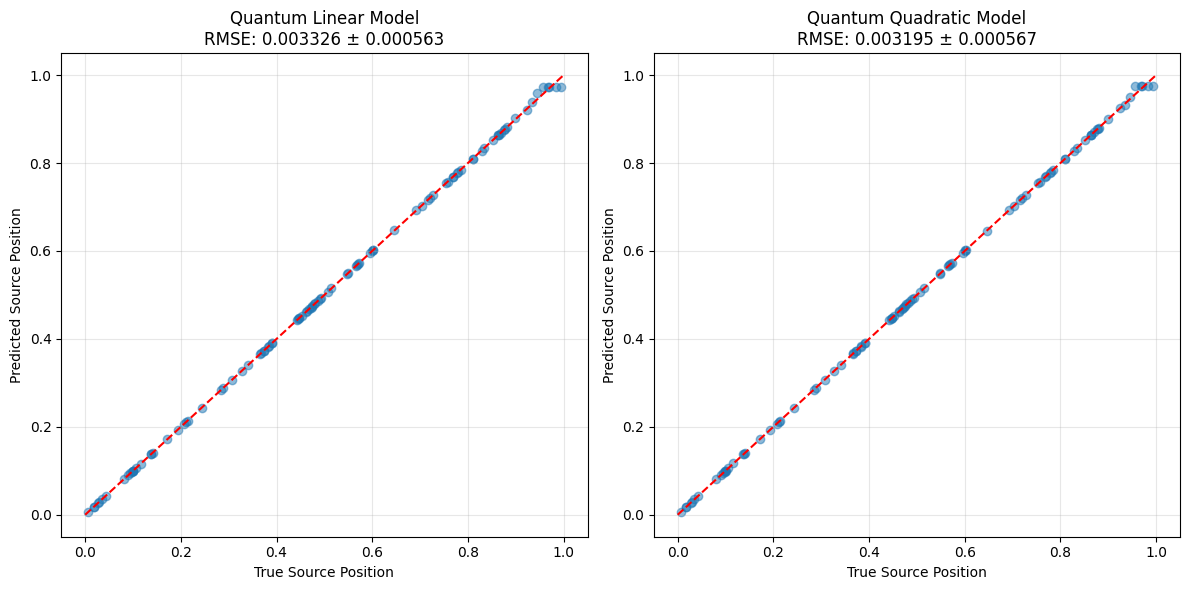


Running experiments with finite sampling and unitary projection
Basic experiment with finite sampling effects
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20

Results with 95% Confidence Intervals (with finite sampling effects):
  - Quantum Linear Model RMSE (95% CI): 0.091412 ± 0.002710
  - Quantum Linear Unitary-Projected RMSE (95% CI): 0.314433 ± 0.009709
  - Quantum Quadratic Model RMSE (95% CI): 0.139761 ± 0.006021
  - Quantum Quadratic Unitary-Projected RMSE (95% CI): 0.280266 ± 0.005956
  - Classical Linear Model RMSE (95% CI): 0.094101 ± 0.002354
  - Classical Quadratic Model RMSE (95% CI): 0.138234 ± 0.005681

Statistical Tests (p-values):
  - Quantum Linear vs. Quantum Quadratic: 0.000000
  - Quantum Linear vs. Quantum Linear Unitary: 0.000000
  - Quantum Quadratic vs. Quantum Quadratic Unitary: 0.000000
  - Quantum Linear Unitary vs.

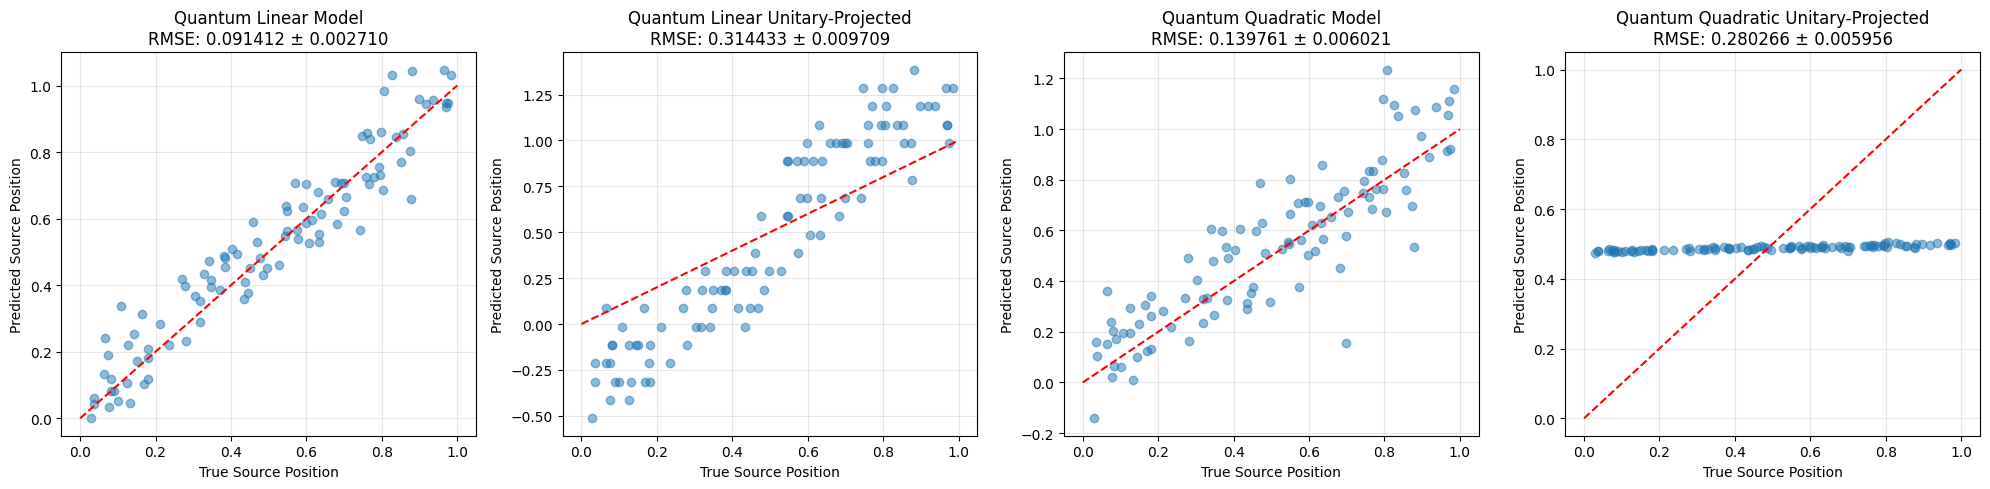


======= SUMMARY OF KEY FINDINGS =======
Basic Experiment Results:
   - Best model: Quantum Quadratic
   - Quantum advantage (linear): Yes
   - Quantum advantage (quadratic): Yes

Finite Sampling and Unitary Projection:
   - Linear model RMSE: 0.091412
   - Unitary-projected RMSE: 0.314433
   - Performance change: 243.97%
   - Statistically significant: Yes


In [40]:
# Basic Experiments (ideal) and Finite Sampling and Unitary Projection
if __name__ == "__main__":

    # Run basic experiment with confidence intervals and statistical tests
    basic_results = run_basic_experiment(n_runs=n_runs, perform_tests=True)

    # Run experiment with finite sampling and unitary projection
    print("\nRunning experiments with finite sampling and unitary projection")
    sampling_results = run_basic_experiment_with_sampling(
        n_runs=n_runs,
        perform_tests=True,
        n_measurements=n_measurements,  # Number of measurements for density matrix reconstruction
        n_pred_samples=n_pred_samples   # Number of samples for prediction
    )

    # Summary of key findings
    print("\n======= SUMMARY OF KEY FINDINGS =======")
    print("Basic Experiment Results:")
    print(f"   - Best model: {'Quantum' if basic_results['rmse_quad_q'] < basic_results['rmse_quad_c'] else 'Classical'} Quadratic")
    print(f"   - Quantum advantage (linear): {'Yes' if basic_results['rmse_linear_q'] < basic_results['rmse_linear_c'] else 'No'}")
    print(f"   - Quantum advantage (quadratic): {'Yes' if basic_results['rmse_quad_q'] < basic_results['rmse_quad_c'] else 'No'}")

    print("\nFinite Sampling and Unitary Projection:")
    print(f"   - Linear model RMSE: {sampling_results['rmse_linear_q']:.6f}")
    print(f"   - Unitary-projected RMSE: {sampling_results['rmse_lin_q_unitary']:.6f}")
    print(f"   - Performance change: {((sampling_results['rmse_lin_q_unitary'] - sampling_results['rmse_linear_q'])/sampling_results['rmse_linear_q']*100):.2f}%")
    print(f"   - Statistically significant: {'Yes' if sampling_results['p_values']['q_linear_vs_q_unitary'] < 0.05 else 'No'}")

##### <font color="blue">*Simulation 3: Noise Impact Analysis*

In [41]:
# Test model performance across different noise levels α
def analyze_noise_impact(noise_levels, quantum_modes=[True, False],
                        degrees=[1, 2], num_samples=num_samples_analyze_noise_impact):
    results = {
        'noise_levels': noise_levels,
    }

    for quantum in quantum_modes:
        data_type = "quantum" if quantum else "classical"
        for degree in degrees:
            model_type = f"{data_type}_degree{degree}"
            results[model_type] = []

            for alpha in noise_levels:
                # Generate and split data - note removal of n_copies parameter
                # Using the new unified generate_dataset function with default parameters
                X, y = generate_dataset(num_samples, alpha, quantum=quantum,
                                       use_empirical_rho=False, low_photon=False)

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

                # Train and evaluate
                rmse, model = train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree)
                results[model_type].append(rmse)

    return results

In [42]:
# Run noise impact analysis with both ideal and sampled models
def run_noise_analysis(n_runs=n_runs, n_measurements=n_measurements, n_pred_samples=n_pred_samples):
    print("Analyzing impact of noise levels on both ideal and realistic models")

    noise_levels = np.linspace(0, 0.9, 10)
    ideal_results = []
    sampled_results = []

    # Helper function to analyze with sampling
    def analyze_noise_impact_with_sampling(noise_levels, n_measurements=n_measurements, n_pred_samples=n_pred_samples):
        results = {
            'noise_levels': noise_levels,
        }

        for quantum in [True, False]:
            data_type = "quantum" if quantum else "classical"
            for degree in [1, 2]:
                model_type = f"{data_type}_degree{degree}"
                results[model_type] = []

                # Quadratic unitary if needed
                if quantum and degree == 2:
                    if 'quantum_quad_unitary' not in results:
                        results['quantum_quad_unitary'] = []

                for alpha in noise_levels:
                    # Generate and split data with sampling using the unified function
                    X, y = generate_dataset(
                        num_samples=num_samples_analyze_noise_impact,
                        alpha=alpha,
                        quantum=quantum,
                        use_empirical_rho=True,  # Use empirical density matrices
                        n_measurements=n_measurements)

                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

                    # Train and evaluate model
                    rmse, model = train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree)

                    # For linear quantum model, also evaluate with unitary projection
                    if quantum and degree == 1:
                        unitary_model = project_to_unitary(model)
                        y_pred = unitary_model.predict(X_test)
                        rmse_unitary = np.sqrt(mean_squared_error(y_test, y_pred))

                        if 'quantum_unitary' not in results:
                            results['quantum_unitary'] = []
                        results['quantum_unitary'].append(rmse_unitary)

                    # For quadratic quantum model, also evaluate with unitary projection
                    if quantum and degree == 2:
                        unitary_quad_model = project_to_unitary(model)
                        y_pred = unitary_quad_model.predict(X_test)
                        rmse_quad_unitary = np.sqrt(mean_squared_error(y_test, y_pred))

                        results['quantum_quad_unitary'].append(rmse_quad_unitary)

                    # Make predictions with sampling for more realism
                    y_pred = predict_with_sampling(model, X_test, n_pred_samples)
                    rmse_sampled = np.sqrt(mean_squared_error(y_test, y_pred))
                    results[model_type].append(rmse_sampled)

        return results

    # Helper function for analyzing with ideal models (no sampling)
    def analyze_noise_impact(noise_levels, quantum_modes=[True, False],
                             degrees=[1, 2], num_samples=num_samples_analyze_noise_impact):
        results = {
            'noise_levels': noise_levels,
        }

        for quantum in quantum_modes:
            data_type = "quantum" if quantum else "classical"
            for degree in degrees:
                model_type = f"{data_type}_degree{degree}"
                results[model_type] = []

                for alpha in noise_levels:
                    # Generate and split data using the unified function with no sampling
                    X, y = generate_dataset(
                        num_samples=num_samples,
                        alpha=alpha,
                        quantum=quantum,
                        use_empirical_rho=False,  # Use theoretical density matrices
                        low_photon=False)

                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

                    # Train and evaluate
                    rmse, _ = train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree)
                    results[model_type].append(rmse)

        return results

    # Run multiple times
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        np.random.seed(42 + run)

        # Analyze with ideal models
        ideal_result = analyze_noise_impact(
            noise_levels,
            quantum_modes=[True, False],
            degrees=[1, 2],
            num_samples=num_samples_analyze_noise_impact)

        ideal_results.append(ideal_result)

        # Analyze with sampling models
        sampled_result = analyze_noise_impact_with_sampling(noise_levels, n_measurements, n_pred_samples)
        sampled_results.append(sampled_result)

    # Process ideal results
    ideal_combined = {
        'noise_levels': noise_levels,
    }

    # Process sampled results
    sampled_combined = {
        'noise_levels': noise_levels,
    }

    # Calculate statistics for each noise level - ideal models
    for noise_idx in range(len(noise_levels)):
        for model_type in ['quantum_degree1', 'quantum_degree2', 'classical_degree1', 'classical_degree2']:
            values = [run_result[model_type][noise_idx] for run_result in ideal_results]
            mean, std_dev, ci = calculate_stats(values)

            if noise_idx == 0:
                ideal_combined[f'{model_type}_mean'] = []
                ideal_combined[f'{model_type}_std'] = []
                ideal_combined[f'{model_type}_ci'] = []

            ideal_combined[f'{model_type}_mean'].append(mean)
            ideal_combined[f'{model_type}_std'].append(std_dev)
            ideal_combined[f'{model_type}_ci'].append(ci)

    # Calculate statistics for each noise level - sampled models
    for noise_idx in range(len(noise_levels)):
        for model_type in ['quantum_degree1', 'quantum_degree2', 'classical_degree1',
                           'classical_degree2', 'quantum_unitary', 'quantum_quad_unitary']:
            if model_type not in sampled_results[0]:
                continue

            values = [run_result[model_type][noise_idx] for run_result in sampled_results]
            mean, std_dev, ci = calculate_stats(values)

            if noise_idx == 0:
                sampled_combined[f'{model_type}_mean'] = []
                sampled_combined[f'{model_type}_std'] = []
                sampled_combined[f'{model_type}_ci'] = []

            sampled_combined[f'{model_type}_mean'].append(mean)
            sampled_combined[f'{model_type}_std'].append(std_dev)
            sampled_combined[f'{model_type}_ci'].append(ci)

    # Plot results for ideal models
    plt.figure(figsize=(10, 6))

    plt.errorbar(noise_levels, ideal_combined['quantum_degree1_mean'],
                 yerr=ideal_combined['quantum_degree1_ci'],
                 fmt='o-', capsize=5, label='Linear (Quantum)')

    plt.errorbar(noise_levels, ideal_combined['quantum_degree2_mean'],
                 yerr=ideal_combined['quantum_degree2_ci'],
                 fmt='s-', capsize=5, label='Quadratic (Quantum)')

    plt.errorbar(noise_levels, ideal_combined['classical_degree1_mean'],
                 yerr=ideal_combined['classical_degree1_ci'],
                 fmt='o--', capsize=5, label='Linear (Classical)')

    plt.errorbar(noise_levels, ideal_combined['classical_degree2_mean'],
                 yerr=ideal_combined['classical_degree2_ci'],
                 fmt='s--', capsize=5, label='Quadratic (Classical)')

    plt.xlabel('Noise Level (α)')
    plt.ylabel('RMSE')
    plt.title('Ideal Model Performance vs Noise Level (with 95% CI)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot results for sampled models
    plt.figure(figsize=(10, 6))

    plt.errorbar(noise_levels, sampled_combined['quantum_degree1_mean'],
                 yerr=sampled_combined['quantum_degree1_ci'],
                 fmt='o-', capsize=5, label='Linear (Quantum)')

    if 'quantum_unitary_mean' in sampled_combined:
        plt.errorbar(noise_levels, sampled_combined['quantum_unitary_mean'],
                    yerr=sampled_combined['quantum_unitary_ci'],
                    fmt='x-', capsize=5, label='Linear Unitary (Quantum)')

    plt.errorbar(noise_levels, sampled_combined['quantum_degree2_mean'],
                 yerr=sampled_combined['quantum_degree2_ci'],
                 fmt='s-', capsize=5, label='Quadratic (Quantum)')

    # Add quadratic unitary model to plot
    if 'quantum_quad_unitary_mean' in sampled_combined:
        plt.errorbar(noise_levels, sampled_combined['quantum_quad_unitary_mean'],
                    yerr=sampled_combined['quantum_quad_unitary_ci'],
                    fmt='d-', capsize=5, label='Quadratic Unitary (Quantum)')

    plt.errorbar(noise_levels, sampled_combined['classical_degree1_mean'],
                 yerr=sampled_combined['classical_degree1_ci'],
                 fmt='o--', capsize=5, label='Linear (Classical)')

    plt.errorbar(noise_levels, sampled_combined['classical_degree2_mean'],
                 yerr=sampled_combined['classical_degree2_ci'],
                 fmt='s--', capsize=5, label='Quadratic (Classical)')

    plt.xlabel('Noise Level (α)')
    plt.ylabel('RMSE')
    plt.title('Sampled Model Performance vs Noise Level (with 95% CI)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Function to find closest index (handles floating point issues)
    def find_closest_idx(arr, value):
        return np.abs(np.array(arr) - value).argmin()

    # Print summary for selected noise levels - ideal models
    print("\nSummary for key noise levels - IDEAL MODELS (with 95% CI):")
    for noise in [0.0, 0.3, 0.6, 0.9]:
        # Find closest index instead of exact match
        noise_idx = find_closest_idx(noise_levels, noise)
        actual_noise = noise_levels[noise_idx]
        print(f"\nAt noise level α = {actual_noise:.1f}:")
        for model in ['quantum_degree1', 'quantum_degree2', 'classical_degree1', 'classical_degree2']:
            model_name = model.replace('_', ' ').title()
            mean = ideal_combined[f'{model}_mean'][noise_idx]
            ci = ideal_combined[f'{model}_ci'][noise_idx]
            print(f"  - {model_name} RMSE (95% CI): {mean:.6f} ± {ci:.6f}")

    # Print summary for selected noise levels - sampled models
    print("\nSummary for key noise levels - SAMPLED MODELS (with 95% CI):")
    for noise in [0.0, 0.3, 0.6, 0.9]:
        # Find closest index instead of exact match
        noise_idx = find_closest_idx(noise_levels, noise)
        actual_noise = noise_levels[noise_idx]
        print(f"\nAt noise level α = {actual_noise:.1f}:")
        # Added 'quantum_quad_unitary' to the list of models to check
        for model in ['quantum_degree1', 'quantum_unitary', 'quantum_degree2',
                      'quantum_quad_unitary', 'classical_degree1', 'classical_degree2']:
            if f'{model}_mean' not in sampled_combined:
                continue
            model_name = model.replace('_', ' ').title()
            mean = sampled_combined[f'{model}_mean'][noise_idx]
            ci = sampled_combined[f'{model}_ci'][noise_idx]
            print(f"  - {model_name} RMSE (95% CI): {mean:.6f} ± {ci:.6f}")

    return ideal_combined, sampled_combined

Analyzing impact of noise levels on both ideal and realistic models
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


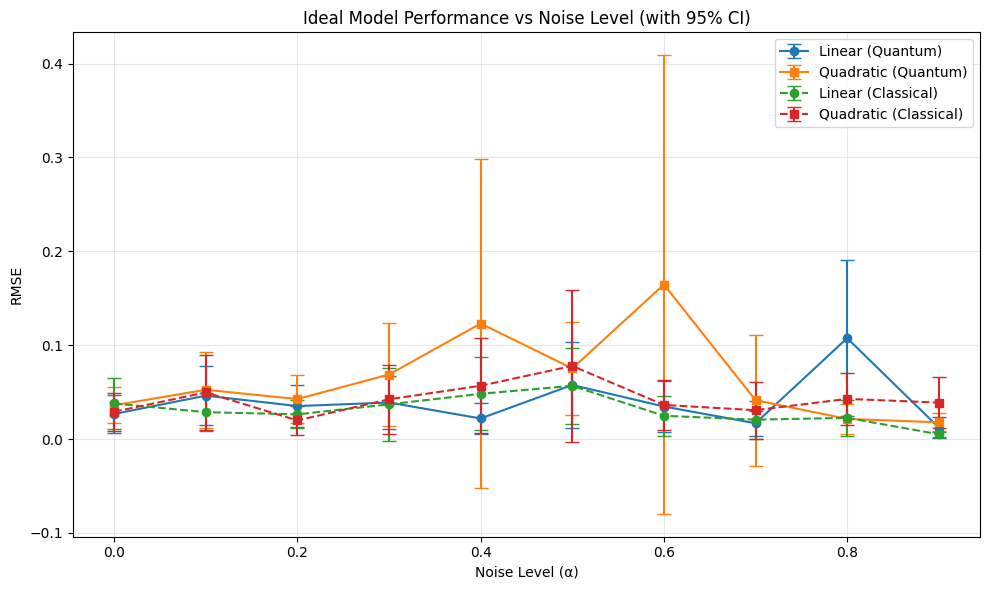

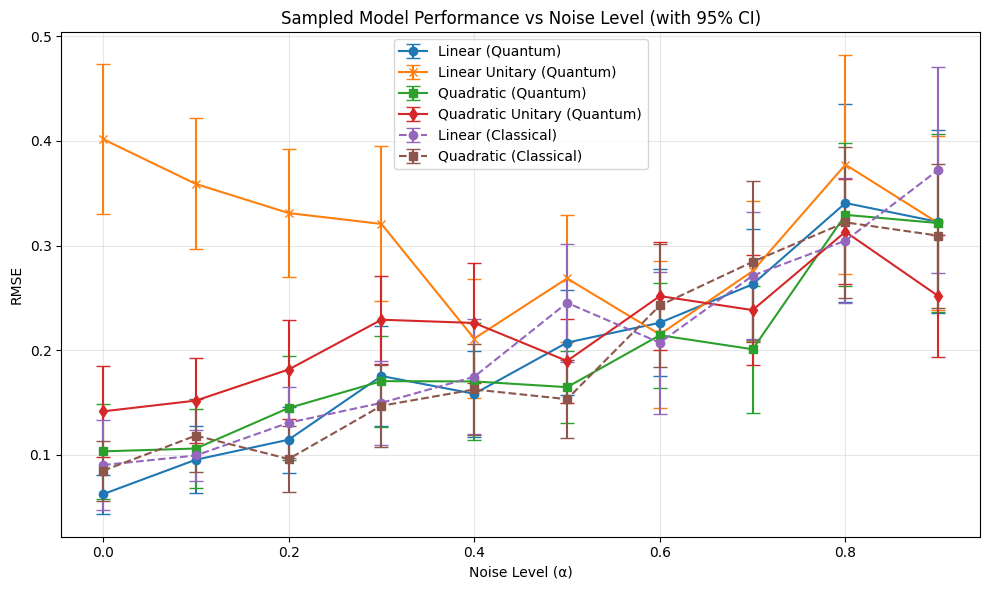


Summary for key noise levels - IDEAL MODELS (with 95% CI):

At noise level α = 0.0:
  - Quantum Degree1 RMSE (95% CI): 0.026665 ± 0.020541
  - Quantum Degree2 RMSE (95% CI): 0.035932 ± 0.019317
  - Classical Degree1 RMSE (95% CI): 0.037844 ± 0.027651
  - Classical Degree2 RMSE (95% CI): 0.029026 ± 0.020420

At noise level α = 0.3:
  - Quantum Degree1 RMSE (95% CI): 0.038882 ± 0.028479
  - Quantum Degree2 RMSE (95% CI): 0.068733 ± 0.055379
  - Classical Degree1 RMSE (95% CI): 0.036906 ± 0.039243
  - Classical Degree2 RMSE (95% CI): 0.042319 ± 0.036894

At noise level α = 0.6:
  - Quantum Degree1 RMSE (95% CI): 0.034636 ± 0.026853
  - Quantum Degree2 RMSE (95% CI): 0.164609 ± 0.244297
  - Classical Degree1 RMSE (95% CI): 0.024744 ± 0.021301
  - Classical Degree2 RMSE (95% CI): 0.036311 ± 0.026344

At noise level α = 0.9:
  - Quantum Degree1 RMSE (95% CI): 0.012218 ± 0.010787
  - Quantum Degree2 RMSE (95% CI): 0.017779 ± 0.009522
  - Classical Degree1 RMSE (95% CI): 0.005048 ± 0.002403
 

In [43]:
# Noise impact analysis with confidence intervals
if __name__ == "__main__":

    noise_results = run_noise_analysis(n_runs=n_runs)

* Linear unitary model performs worse than regular linear model, better than classical only at high noise, degrades significantly from ideal, but surprisingly improves with increasing noise.
* Quadratic unitary model generally outperforms regular quadratic model, better than classical at high noise, worse at low noise, also degrades from ideal but less dramatically with noise.
* Quadratic unitary model consistently outperforms the linear unitary model across all noise levels.
* Optimal model choice depends on noise levels: regular quantum models better at low noise, quadratic unitary best at high noise.
* Both unitary models show high performance variability and a substantial gap compared to the theoretical ideal.
* Unitary projection seems more beneficial for the quadratic model, especially in noisy environments.

##### <font color="blue">*Simulation 4: Low Photon Count Analysis with Limits Analysis (Empirical Results vs Theoretical Bounds)*

***Classical limits for noise model***

The fundamental limit to how much information we can extract from a single measurement of quantum state $\rho$ that represents a source at position $s$ (related to quantum Cramér-Rao bound for parameter estimation). For $n$ identical copies of $\rho$, the joint state is the tensor product

> $\rho^{\otimes n} = \underbrace{\rho \otimes \rho \otimes ... \otimes \rho}_{n \text{ times}}$

with the Fisher information we can determine how precisely we can estimate $s$, which scales linearly with the number of copies

> $F_n(s) = n \cdot F_1(s)$

The precision limit improves by a factor of $\sqrt{n}$

> $\Delta s_{min} \propto \frac{1}{\sqrt{F_n(s)}} = \frac{1}{\sqrt{n \cdot F_1(s)}} = \frac{1}{\sqrt{n}} \cdot \frac{1}{\sqrt{F_1(s)}}$

The statistical variance in phase estimation at sensor $j$ due to noise can be as follows. It shows that phase uncertainty increases with noise level $\alpha$ and decreases with signal strength at that sensor:

> $\text{Var}[\arg(\rho_{jj})] \approx \frac{\alpha}{2(1-\alpha)|\phi_j(s)|^2}$

For sensors beyond the cutoff length $l$ from source, the signal-to-noise ratio decreases exponentially and limits information to sensors within range $l$ of source s:

> $\text{SNR}_j \propto \exp\left(-\frac{|s - j\delta|}{l}\right)$

The classical information is in the diagonal elements of the density matrix (probability of detecting the photon at sensor $j$)

> $\rho_{jj} = (1-\alpha)|\phi_j(s)|^2 + \alpha\frac{1}{d}$

The theoretical minimum variance for an unbiased estimator of source position $s$ using only classical information is (cramér-rao bound for classical localization)

> $\text{Var}(s_{est}) \geq \frac{1}{F_C(s)}$

$F_C(s)$ is fisher information:

> $F_C(s) = \sum_{j=0}^{d-1} \frac{1}{\rho_{jj}} \left(\frac{\partial \rho_{jj}}{\partial s}\right)^2$

Potential quantum advantage comes from ratio of quantum Fisher information to classical Fisher information ($F_Q(s)$ includes phase information in the off-diagonal elements of $\rho$):

> $\eta = \frac{F_Q(s)}{F_C(s)}$

With cutoff length $l$ and noise level $\alpha$ the classical localization precision limit can be approximately at

> $\Delta s_{min} \approx \frac{l}{\sqrt{N_{eff}}}$

$N_{eff} \approx \frac{l}{\delta}(1-\alpha)$ is the number of sensors that contribute meaningful information.

**The theoretical framework suggests that quantum advantage should scale as η = F_Q(s)/F_C(s), which gives the theoretical maximum advantage possible. The empirical results would show how much of this theoretical advantage is captured with the machine learning approaches.** Fully compare with the theoretical bounds:
* calculate F_C(s) and F_Q(s) for each photon count scenario
* compute the theoretical minimum variance from these Fisher information values
* compare the empirical MSE (square of RMSE) with these theoretical minimums
* determine what percentage of the theoretical quantum advantage is achieved



In [44]:
# Analyze impact of low photon numbers on model performance
def run_low_photon_analysis(n_runs=n_runs, photon_counts=photon_counts, verbose=False):
    # List from photon_counts as input, loops through each value
    all_results = []

    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        np.random.seed(42 + run)

        run_results = {
            'photon_counts': photon_counts,
            'quantum_linear': [],
            'quantum_linear_unitary': [],
            'quantum_quadratic': [],
            'quantum_quadratic_unitary': [],
            'classical_linear': [],
            'classical_quadratic': []
        }

        # Show progress indicator if not in verbose mode
        if not verbose:
            print(f"  Processing {len(photon_counts)} photon counts", end="", flush=True)

        for avg_photons in photon_counts:
            # Only print detailed messages in verbose mode
            if verbose:
                print(f"  Tests with {avg_photons} average photons")

            # Generate quantum data with finite sampling using unified function
            X_quantum, y_quantum = generate_dataset(
                num_samples, alpha,
                quantum=True,
                use_empirical_rho=True,
                low_photon=True,
                n_measurements=n_measurements,
                avg_photons=avg_photons)

            X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantum, y_quantum, test_size=0.2)

            # Generate classical data with finite sampling using unified function
            X_classical, y_classical = generate_dataset(
                num_samples, alpha,
                quantum=False,
                use_empirical_rho=True,
                low_photon=True,
                n_measurements=n_measurements,
                avg_photons=avg_photons)

            X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classical, y_classical, test_size=0.2)

            # Train and evaluate linear models
            rmse_linear_q, linear_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=1)
            rmse_linear_c, linear_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=1)

            # Train and evaluate quadratic models
            rmse_quad_q, quad_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=2)
            rmse_quad_c, quad_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=2)

            # Project linear quantum model to unitary space
            unitary_model_q = project_to_unitary(linear_model_q)
            y_pred_unitary = unitary_model_q.predict(X_test_q)
            rmse_lin_q_unitary = np.sqrt(mean_squared_error(y_test_q, y_pred_unitary))

            # Project quadratic quantum model to unitary space
            unitary_quad_model_q = project_to_unitary(quad_model_q)
            y_pred_quad_unitary = unitary_quad_model_q.predict(X_test_q)
            rmse_quad_q_unitary = np.sqrt(mean_squared_error(y_test_q, y_pred_quad_unitary))

            # Store results
            run_results['quantum_linear'].append(rmse_linear_q)
            run_results['quantum_linear_unitary'].append(rmse_lin_q_unitary)
            run_results['quantum_quadratic'].append(rmse_quad_q)
            run_results['quantum_quadratic_unitary'].append(rmse_quad_q_unitary)
            run_results['classical_linear'].append(rmse_linear_c)
            run_results['classical_quadratic'].append(rmse_quad_c)

        # Completion message
        if not verbose:
            print(" Finished")

        all_results.append(run_results)

    # Process results
    combined_results = {
        'photon_counts': photon_counts,
    }

    # Calculate statistics for each photon count and each model
    for model_type in ['quantum_linear', 'quantum_linear_unitary', 'quantum_quadratic',
                       'quantum_quadratic_unitary', 'classical_linear', 'classical_quadratic']:
        combined_results[f'{model_type}_mean'] = []
        combined_results[f'{model_type}_std'] = []
        combined_results[f'{model_type}_ci'] = []

        for photon_idx in range(len(photon_counts)):
            values = [run_result[model_type][photon_idx] for run_result in all_results]
            mean, std_dev, ci = calculate_stats(values)

            combined_results[f'{model_type}_mean'].append(mean)
            combined_results[f'{model_type}_std'].append(std_dev)
            combined_results[f'{model_type}_ci'].append(ci)

    # Calculate quantum advantage metrics (for both linear and quadratic)
    combined_results['quantum_linear_advantage'] = []
    combined_results['quantum_linear_advantage_ci'] = []
    combined_results['quantum_quadratic_advantage'] = []
    combined_results['quantum_quadratic_advantage_ci'] = []

    for i in range(len(photon_counts)):
        # Calculate relative advantage for linear models
        q_linear_mean = combined_results['quantum_linear_mean'][i]
        c_linear_mean = combined_results['classical_linear_mean'][i]

        # Relative improvement for linear models
        if c_linear_mean > 0:
            linear_advantage = (c_linear_mean - q_linear_mean) / c_linear_mean
        else:
            linear_advantage = 0

        # Error propagation for linear advantage
        q_linear_ci = combined_results['quantum_linear_ci'][i]
        c_linear_ci = combined_results['classical_linear_ci'][i]
        linear_advantage_ci = np.sqrt((q_linear_ci/c_linear_mean)**2 +
                                     (c_linear_ci*q_linear_mean/c_linear_mean**2)**2) if c_linear_mean > 0 else 0

        combined_results['quantum_linear_advantage'].append(linear_advantage)
        combined_results['quantum_linear_advantage_ci'].append(linear_advantage_ci)

        # Calculate relative advantage for quadratic models
        q_quad_mean = combined_results['quantum_quadratic_mean'][i]
        c_quad_mean = combined_results['classical_quadratic_mean'][i]

        # Relative improvement for quadratic models
        if c_quad_mean > 0:
            quad_advantage = (c_quad_mean - q_quad_mean) / c_quad_mean
        else:
            quad_advantage = 0

        # Error propagation for quadratic advantage
        q_quad_ci = combined_results['quantum_quadratic_ci'][i]
        c_quad_ci = combined_results['classical_quadratic_ci'][i]
        quad_advantage_ci = np.sqrt((q_quad_ci/c_quad_mean)**2 +
                                   (c_quad_ci*q_quad_mean/c_quad_mean**2)**2) if c_quad_mean > 0 else 0

        combined_results['quantum_quadratic_advantage'].append(quad_advantage)
        combined_results['quantum_quadratic_advantage_ci'].append(quad_advantage_ci)

    # Plot enhanced results with quadratic models
    plt.figure(figsize=(14, 12))

    # Plot 1: RMSE for Linear Models vs Photon Counts
    plt.subplot(2, 2, 1)
    plt.errorbar(photon_counts, combined_results['quantum_linear_mean'],
                 yerr=combined_results['quantum_linear_ci'],
                 fmt='o-', capsize=5, label='Quantum Linear')

    plt.errorbar(photon_counts, combined_results['quantum_linear_unitary_mean'],
                 yerr=combined_results['quantum_linear_unitary_ci'],
                 fmt='x-', capsize=5, label='Quantum Linear Unitary')

    plt.errorbar(photon_counts, combined_results['classical_linear_mean'],
                 yerr=combined_results['classical_linear_ci'],
                 fmt='s--', capsize=5, label='Classical Linear')

    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('RMSE')
    plt.title('Linear Model Performance vs. Average Photon Count')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: RMSE for Quadratic Models vs Photon Counts
    plt.subplot(2, 2, 2)
    plt.errorbar(photon_counts, combined_results['quantum_quadratic_mean'],
                 yerr=combined_results['quantum_quadratic_ci'],
                 fmt='o-', capsize=5, label='Quantum Quadratic')

    plt.errorbar(photon_counts, combined_results['quantum_quadratic_unitary_mean'],
                 yerr=combined_results['quantum_quadratic_unitary_ci'],
                 fmt='x-', capsize=5, label='Quantum Quadratic Unitary')

    plt.errorbar(photon_counts, combined_results['classical_quadratic_mean'],
                 yerr=combined_results['classical_quadratic_ci'],
                 fmt='s--', capsize=5, label='Classical Quadratic')

    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('RMSE')
    plt.title('Quadratic Model Performance vs. Average Photon Count')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 3: Linear Quantum Advantage vs Photon Counts
    plt.subplot(2, 2, 3)
    plt.errorbar(photon_counts, combined_results['quantum_linear_advantage'],
                 yerr=combined_results['quantum_linear_advantage_ci'],
                 fmt='o-', capsize=5, color='blue')

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Linear Quantum Advantage\n(relative improvement)')
    plt.title('Linear Quantum Advantage vs. Average Photon Count')
    plt.grid(True, alpha=0.3)

    # Plot 4: Quadratic Quantum Advantage vs Photon Counts
    plt.subplot(2, 2, 4)
    plt.errorbar(photon_counts, combined_results['quantum_quadratic_advantage'],
                 yerr=combined_results['quantum_quadratic_advantage_ci'],
                 fmt='o-', capsize=5, color='purple')

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Quadratic Quantum Advantage\n(relative improvement)')
    plt.title('Quadratic Quantum Advantage vs. Average Photon Count')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary with expanded models
    print("\nSummary of Low Photon Number Analysis:")
    print("\nRMSE for different photon counts (with 95% CI):")

    for i, photons in enumerate(photon_counts):
        print(f"\nAverage photon count: {photons}")
        print("Linear Models:")
        print(f"  - Quantum Linear RMSE: {combined_results['quantum_linear_mean'][i]:.6f} ± {combined_results['quantum_linear_ci'][i]:.6f}")
        print(f"  - Quantum Linear Unitary RMSE: {combined_results['quantum_linear_unitary_mean'][i]:.6f} ± {combined_results['quantum_linear_unitary_ci'][i]:.6f}")
        print(f"  - Classical Linear RMSE: {combined_results['classical_linear_mean'][i]:.6f} ± {combined_results['classical_linear_ci'][i]:.6f}")
        print(f"  - Linear Quantum Advantage: {combined_results['quantum_linear_advantage'][i]*100:.2f}% ± {combined_results['quantum_linear_advantage_ci'][i]*100:.2f}%")

        print("Quadratic Models:")
        print(f"  - Quantum Quadratic RMSE: {combined_results['quantum_quadratic_mean'][i]:.6f} ± {combined_results['quantum_quadratic_ci'][i]:.6f}")
        print(f"  - Quantum Quadratic Unitary RMSE: {combined_results['quantum_quadratic_unitary_mean'][i]:.6f} ± {combined_results['quantum_quadratic_unitary_ci'][i]:.6f}")
        print(f"  - Classical Quadratic RMSE: {combined_results['classical_quadratic_mean'][i]:.6f} ± {combined_results['classical_quadratic_ci'][i]:.6f}")
        print(f"  - Quadratic Quantum Advantage: {combined_results['quantum_quadratic_advantage'][i]*100:.2f}% ± {combined_results['quantum_quadratic_advantage_ci'][i]*100:.2f}%")

    return combined_results

# Quantum shot noise for low photon count regimes
#if __name__ == "__main__":
#    low_photon_results = run_low_photon_analysis(
#        n_runs=n_runs,
#        photon_counts=photon_counts
#    )

In [45]:
# Calculate Classical Fisher Information for source position s
def calculate_classical_fisher_information(s, alpha, L, d, k, l):
    sensor_positions = np.linspace(0, L, d, endpoint=False)

    # Compute state at parameter s (for normalization factor calculations)
    cutoff_factor_s = np.exp(-np.abs(s - sensor_positions) / l)
    normalization_s = np.sqrt(np.sum(cutoff_factor_s**2))
    amplitudes_s = cutoff_factor_s / normalization_s
    probabilities_s = amplitudes_s**2

    # Compute derivatives of normalization factor
    # d/ds (sqrt(sum(exp(-2|s-x_j|/l)))) requires chain rule
    d_cutoff_ds = np.zeros_like(cutoff_factor_s)
    for j in range(d):
        sign = 1.0 if s < sensor_positions[j] else -1.0
        d_cutoff_ds[j] = sign * (1.0/l) * cutoff_factor_s[j]

    # Derivative of squared norm
    d_norm_squared_ds = 2 * np.sum(cutoff_factor_s * d_cutoff_ds)

    # Derivative of normalization factor
    d_norm_ds = 0.5 * d_norm_squared_ds / normalization_s

    # Compute Classical Fisher Information
    F_C = 0.0

    for j in range(d):
        # Distance from source to sensor
        distance = np.abs(s - sensor_positions[j])

        # Sign of derivative
        sign = 1.0 if s < sensor_positions[j] else -1.0

        # Full derivative calculation for amplitude
        # d/ds(exp(-|s-x_j|/l)/norm) = (-sign/l)*exp(-|s-x_j|/l)/norm - exp(-|s-x_j|/l)*d_norm_ds/norm^2
        d_amplitude_ds = ((-sign/l) * cutoff_factor_s[j] / normalization_s) - \
                         (cutoff_factor_s[j] * d_norm_ds / (normalization_s**2))

        # Derivative of probability (amplitude squared)
        d_prob_ds = 2 * amplitudes_s[j] * d_amplitude_ds

        # Diagonal element of density matrix (detection probability)
        rho_jj = (1 - alpha) * probabilities_s[j] + alpha/d

        # Derivative of rho_jj with respect to s
        drho_jj_ds = (1 - alpha) * d_prob_ds

        # Add contribution to Fisher information
        if rho_jj > 0 and drho_jj_ds != 0:
            F_C += (drho_jj_ds**2) / rho_jj

    return F_C

In [46]:
# Calculate Quantum Fisher Information for source position s using full eigendecomposition
def calculate_quantum_fisher_information(s, alpha, L=1.0, d=20, k=5, l=0.3):
    # Sensor positions
    sensor_positions = np.linspace(0, L, d, endpoint=False)

    # Create pure state for source at position s
    phases = -2 * np.pi * k * (s - sensor_positions)
    cutoff_factor = np.exp(-np.abs(s - sensor_positions) / l)
    normalization = np.sqrt(np.sum(cutoff_factor**2))
    amplitudes = cutoff_factor / normalization
    state = amplitudes * np.exp(1j * phases)

    # Pure state density matrix
    rho_pure = np.outer(state, np.conjugate(state))

    # Mixed state density matrix with noise
    rho_mixed = np.eye(d) / d
    rho = (1 - alpha) * rho_pure + alpha * rho_mixed

    # Calculate derivative of state with respect to s

    # Derivative of phases: d(phases)/ds = 2π * k
    d_phases_ds = 2 * np.pi * k * np.ones_like(phases)

    # Derivative of cutoff factors
    d_cutoff_ds = np.zeros_like(cutoff_factor)
    for j in range(d):
        sign = 1.0 if s < sensor_positions[j] else -1.0
        d_cutoff_ds[j] = sign * (1.0/l) * cutoff_factor[j]

    # Derivative of normalization factor
    d_norm_squared_ds = 2 * np.sum(cutoff_factor * d_cutoff_ds)
    d_norm_ds = 0.5 * d_norm_squared_ds / normalization

    # Full derivative of amplitudes
    d_amplitudes_ds = np.zeros_like(amplitudes)
    for j in range(d):
        sign = 1.0 if s < sensor_positions[j] else -1.0
        d_amplitudes_ds[j] = ((-sign/l) * cutoff_factor[j] / normalization) - \
                            (cutoff_factor[j] * d_norm_ds / (normalization**2))

    # Full derivative of state with both amplitude and phase changes
    d_state_ds = (d_amplitudes_ds * np.exp(1j * phases)) + \
                 (1j * d_phases_ds * state)

    # Calculate d(rho)/ds for the pure state component
    d_rho_pure_ds = np.outer(d_state_ds, np.conjugate(state)) + \
                   np.outer(state, np.conjugate(d_state_ds))

    # Derivative of the full density matrix
    d_rho_ds = (1 - alpha) * d_rho_pure_ds

    # Full eigendecomposition of rho for proper QFI calculation
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Calculate Symmetric Logarithmic Derivative (SLD)
    SLD = np.zeros((d, d), dtype=complex)

    # Loop through all eigenpairs
    for i in range(d):
        for j in range(d):
            # Avoid division by zero by checking eigenvalue sum
            if eigenvalues[i] + eigenvalues[j] > 1e-10:
                # Matrix element of d_rho_ds in eigenbasis
                d_rho_element = np.vdot(eigenvectors[:, i],
                                       d_rho_ds @ eigenvectors[:, j])

                # SLD element
                SLD_element = 2 * d_rho_element / (eigenvalues[i] + eigenvalues[j])

                # Add to SLD matrix
                SLD += SLD_element * np.outer(eigenvectors[:, i],
                                            np.conjugate(eigenvectors[:, j]))

    # Calculate QFI = Tr(ρ L²) - Mathematically equivalent to Tr(L ρ L)
    F_Q = 0.0

    # Full calculation of QFI using eigenvalues and SLD matrix elements
    for i in range(d):
        for j in range(d):
            if eigenvalues[i] > 1e-10:  # Only consider non-zero eigenvalues
                # Get SLD matrix element in eigenbasis
                L_ij = np.vdot(eigenvectors[:, i], SLD @ eigenvectors[:, j])

                # Contribution to QFI
                F_Q += eigenvalues[i] * np.abs(L_ij)**2

    # Alternative equivalent calculation: F_Q = Tr(d_rho_ds @ SLD)
    # F_Q_alt = np.real(np.trace(d_rho_ds @ SLD))

    # Ensure result is real
    return np.real(F_Q)

In [47]:
# Calculate average Fisher information over different source positions
def calculate_average_fisher_information(alpha, L, d, k, l, n_positions=20):
    # Sample different source positions
    source_positions = np.linspace(0, L, n_positions)

    # Track Fisher information for each position
    F_C_values = []
    F_Q_values = []

    for s in source_positions:
        # Calculate Fisher information for this source position
        F_C = calculate_classical_fisher_information(s, alpha, L, d, k, l)
        F_Q = calculate_quantum_fisher_information(s, alpha, L, d, k, l)

        F_C_values.append(F_C)
        F_Q_values.append(F_Q)

    # Calculate averages
    avg_F_C = np.mean(F_C_values)
    avg_F_Q = np.mean(F_Q_values)

    return avg_F_C, avg_F_Q

In [48]:
# Calculate theoretical precision limits for different photon counts with Fisher calculations
def calculate_theoretical_limits(photon_counts, alpha, n_measurements=n_measurements, L=L, d=d, k=k, l=l):
    results = {
        'photon_counts': photon_counts,
        'classical_crb': [],          # Classical Cramér-Rao Bound
        'quantum_crb': [],            # Quantum Cramér-Rao Bound
        'quantum_advantage_ratio': [] # Theoretical quantum advantage ratio
    }

    # Pre-calculate average Fisher information for base noise level
    print("Pre-calculating average Fisher information...")
    base_F_C, base_F_Q = calculate_average_fisher_information(alpha, L, d, k, l)

    for avg_photons in photon_counts:
        print(f"Calculating theoretical limits for {avg_photons} photons")

        # Calculate effective noise based on photon count
        # For very low photon counts, many measurements give no information
        prob_no_photon = np.exp(-avg_photons)

        # Effective parameters accounting for failed measurements
        effective_measurements = n_measurements * (1 - prob_no_photon)

        # Scale Fisher information by number of effective measurements
        F_C_total = base_F_C * effective_measurements
        F_Q_total = base_F_Q * effective_measurements

        # Calculate Cramér-Rao bounds
        if F_C_total > 0:
            classical_crb = 1 / np.sqrt(F_C_total)
        else:
            classical_crb = np.inf

        if F_Q_total > 0:
            quantum_crb = 1 / np.sqrt(F_Q_total)
        else:
            quantum_crb = np.inf

        # Calculate theoretical quantum advantage ratio
        if F_C_total > 0:
            quantum_advantage_ratio = np.sqrt(F_Q_total / F_C_total) - 1  # Relative improvement
        else:
            quantum_advantage_ratio = np.inf

        # Store results
        results['classical_crb'].append(classical_crb)
        results['quantum_crb'].append(quantum_crb)
        results['quantum_advantage_ratio'].append(quantum_advantage_ratio)

    return results

In [49]:
# Compare empirical performance with theoretical limits
def compare_empirical_with_theory(empirical_results, theoretical_results):
    comparison = {
        'photon_counts': empirical_results['photon_counts'],
        'empirical_quantum_linear_rmse': empirical_results['quantum_linear_mean'],
        'empirical_quantum_linear_unitary_rmse': empirical_results['quantum_linear_unitary_mean'],
        'empirical_quantum_quadratic_rmse': empirical_results['quantum_quadratic_mean'],
        'empirical_quantum_quadratic_unitary_rmse': empirical_results['quantum_quadratic_unitary_mean'],
        'empirical_classical_linear_rmse': empirical_results['classical_linear_mean'],
        'empirical_classical_quadratic_rmse': empirical_results['classical_quadratic_mean'],
        'theoretical_quantum_crb': theoretical_results['quantum_crb'],
        'theoretical_classical_crb': theoretical_results['classical_crb'],
        'theoretical_advantage_ratio': theoretical_results['quantum_advantage_ratio'],
        'empirical_linear_advantage_ratio': [],
        'empirical_quadratic_advantage_ratio': [],
        'quantum_linear_efficiency_ratio': [],            # How close empirical quantum linear is to quantum CRB
        'quantum_linear_unitary_efficiency_ratio': [],    # How close empirical quantum linear unitary is to quantum CRB
        'quantum_quadratic_efficiency_ratio': [],         # How close empirical quantum quadratic is to quantum CRB
        'quantum_quadratic_unitary_efficiency_ratio': [], # How close empirical quantum quadratic unitary is to quantum CRB
        'classical_linear_efficiency_ratio': [],          # How close empirical classical linear is to classical CRB
        'classical_quadratic_efficiency_ratio': []        # How close empirical classical quadratic is to classical CRB
    }

    # Calculate comparison metrics
    for i in range(len(empirical_results['photon_counts'])):
        # Empirical linear advantage ratio
        if comparison['empirical_classical_linear_rmse'][i] > 0:
            empirical_linear_advantage = (comparison['empirical_classical_linear_rmse'][i] /
                                 comparison['empirical_quantum_linear_rmse'][i]) - 1
        else:
            empirical_linear_advantage = np.nan

        # Empirical quadratic advantage ratio
        if comparison['empirical_classical_quadratic_rmse'][i] > 0:
            empirical_quadratic_advantage = (comparison['empirical_classical_quadratic_rmse'][i] /
                                    comparison['empirical_quantum_quadratic_rmse'][i]) - 1
        else:
            empirical_quadratic_advantage = np.nan

        # Efficiency ratios for quantum models (how close to theoretical optimum)
        if comparison['theoretical_quantum_crb'][i] > 0:
            # Linear models
            quantum_linear_efficiency = comparison['theoretical_quantum_crb'][i] / comparison['empirical_quantum_linear_rmse'][i]
            quantum_linear_unitary_efficiency = comparison['theoretical_quantum_crb'][i] / comparison['empirical_quantum_linear_unitary_rmse'][i]

            # Quadratic models
            quantum_quadratic_efficiency = comparison['theoretical_quantum_crb'][i] / comparison['empirical_quantum_quadratic_rmse'][i]
            quantum_quadratic_unitary_efficiency = comparison['theoretical_quantum_crb'][i] / comparison['empirical_quantum_quadratic_unitary_rmse'][i]
        else:
            quantum_linear_efficiency = np.nan
            quantum_linear_unitary_efficiency = np.nan
            quantum_quadratic_efficiency = np.nan
            quantum_quadratic_unitary_efficiency = np.nan

        # Efficiency ratios for classical models
        if comparison['theoretical_classical_crb'][i] > 0:
            classical_linear_efficiency = comparison['theoretical_classical_crb'][i] / comparison['empirical_classical_linear_rmse'][i]
            classical_quadratic_efficiency = comparison['theoretical_classical_crb'][i] / comparison['empirical_classical_quadratic_rmse'][i]  # Added
        else:
            classical_linear_efficiency = np.nan
            classical_quadratic_efficiency = np.nan

        comparison['empirical_linear_advantage_ratio'].append(empirical_linear_advantage)
        comparison['empirical_quadratic_advantage_ratio'].append(empirical_quadratic_advantage)
        comparison['quantum_linear_efficiency_ratio'].append(quantum_linear_efficiency)
        comparison['quantum_linear_unitary_efficiency_ratio'].append(quantum_linear_unitary_efficiency)
        comparison['quantum_quadratic_efficiency_ratio'].append(quantum_quadratic_efficiency)
        comparison['quantum_quadratic_unitary_efficiency_ratio'].append(quantum_quadratic_unitary_efficiency)
        comparison['classical_linear_efficiency_ratio'].append(classical_linear_efficiency)
        comparison['classical_quadratic_efficiency_ratio'].append(classical_quadratic_efficiency)

    return comparison

In [50]:
# Visualize comparison between empirical results and theoretical limits
def plot_theoretical_comparison(comparison):
    plt.figure(figsize=(14, 18))

    # Plot 1: Empirical RMSE for Linear Models vs. Theoretical Limits
    plt.subplot(3, 2, 1)
    plt.errorbar(comparison['photon_counts'], comparison['empirical_quantum_linear_rmse'],
                 fmt='o-', capsize=5, label='Empirical Quantum Linear')
    plt.errorbar(comparison['photon_counts'], comparison['empirical_quantum_linear_unitary_rmse'],
                 fmt='x-', capsize=5, label='Empirical Quantum Linear Unitary')
    plt.errorbar(comparison['photon_counts'], comparison['empirical_classical_linear_rmse'],
                 fmt='s--', capsize=5, label='Empirical Classical Linear')
    plt.plot(comparison['photon_counts'], comparison['theoretical_quantum_crb'],
             'k-', linewidth=2, label='Quantum Cramér-Rao Bound')
    plt.plot(comparison['photon_counts'], comparison['theoretical_classical_crb'],
             'k--', linewidth=2, label='Classical Cramér-Rao Bound')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('RMSE / √Variance')
    plt.title('Linear Model Performance vs. Theoretical Limits')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: Empirical RMSE for Quadratic Models vs. Theoretical Limits (Added)
    plt.subplot(3, 2, 2)
    plt.errorbar(comparison['photon_counts'], comparison['empirical_quantum_quadratic_rmse'],
                 fmt='o-', capsize=5, label='Empirical Quantum Quadratic')
    plt.errorbar(comparison['photon_counts'], comparison['empirical_quantum_quadratic_unitary_rmse'],
                 fmt='x-', capsize=5, label='Empirical Quantum Quadratic Unitary')
    plt.errorbar(comparison['photon_counts'], comparison['empirical_classical_quadratic_rmse'],
                 fmt='s--', capsize=5, label='Empirical Classical Quadratic')
    plt.plot(comparison['photon_counts'], comparison['theoretical_quantum_crb'],
             'k-', linewidth=2, label='Quantum Cramér-Rao Bound')
    plt.plot(comparison['photon_counts'], comparison['theoretical_classical_crb'],
             'k--', linewidth=2, label='Classical Cramér-Rao Bound')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('RMSE / √Variance')
    plt.title('Quadratic Model Performance vs. Theoretical Limits')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 3: Theoretical vs. Empirical Quantum Advantage for Linear Models
    plt.subplot(3, 2, 3)
    plt.plot(comparison['photon_counts'], comparison['theoretical_advantage_ratio'],
             'k-', linewidth=2, label='Theoretical Quantum Advantage')
    plt.plot(comparison['photon_counts'], comparison['empirical_linear_advantage_ratio'],
             'bo-', label='Empirical Linear Quantum Advantage')

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Relative Advantage\n(Improvement Ratio)')
    plt.title('Theoretical vs. Empirical Linear Quantum Advantage')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 4: Theoretical vs. Empirical Quantum Advantage for Quadratic Models
    plt.subplot(3, 2, 4)
    plt.plot(comparison['photon_counts'], comparison['theoretical_advantage_ratio'],
             'k-', linewidth=2, label='Theoretical Quantum Advantage')
    plt.plot(comparison['photon_counts'], comparison['empirical_quadratic_advantage_ratio'],
             'mo-', label='Empirical Quadratic Quantum Advantage')

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Relative Advantage\n(Improvement Ratio)')
    plt.title('Theoretical vs. Empirical Quadratic Quantum Advantage')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 5: Linear Model Efficiency Ratios
    plt.subplot(3, 2, 5)
    plt.plot(comparison['photon_counts'], comparison['quantum_linear_efficiency_ratio'],
             'bo-', label='Quantum Linear Efficiency')
    plt.plot(comparison['photon_counts'], comparison['quantum_linear_unitary_efficiency_ratio'],
             'go-', label='Quantum Linear Unitary Efficiency')
    plt.plot(comparison['photon_counts'], comparison['classical_linear_efficiency_ratio'],
             'ro--', label='Classical Linear Efficiency')

    plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.7,
                label='Theoretical Optimum')
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Efficiency Ratio\n(Theoretical/Empirical)')
    plt.title('Linear Model Efficiency: How Close to Theoretical Optimum')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 6: Quadratic Model Efficiency Ratios
    plt.subplot(3, 2, 6)
    plt.plot(comparison['photon_counts'], comparison['quantum_quadratic_efficiency_ratio'],
             'mo-', label='Quantum Quadratic Efficiency')
    plt.plot(comparison['photon_counts'], comparison['quantum_quadratic_unitary_efficiency_ratio'],
             'co-', label='Quantum Quadratic Unitary Efficiency')
    plt.plot(comparison['photon_counts'], comparison['classical_quadratic_efficiency_ratio'],
             'yo--', label='Classical Quadratic Efficiency')

    plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.7,
                label='Theoretical Optimum')
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Efficiency Ratio\n(Theoretical/Empirical)')
    plt.title('Quadratic Model Efficiency: How Close to Theoretical Optimum')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nSummary of Theoretical Comparison:")
    print("\nLinear Models:")
    print("Photon Count | Empirical Linear Advantage | Theoretical Advantage | Quantum Linear Efficiency | Unitary Linear Efficiency | Classical Linear Efficiency")
    print("-" * 135)

    for i, photons in enumerate(comparison['photon_counts']):
        print(f"{photons:11.3f} | {comparison['empirical_linear_advantage_ratio'][i]*100:22.2f}% | {comparison['theoretical_advantage_ratio'][i]*100:20.2f}% | {comparison['quantum_linear_efficiency_ratio'][i]:23.4f} | {comparison['quantum_linear_unitary_efficiency_ratio'][i]:23.4f} | {comparison['classical_linear_efficiency_ratio'][i]:25.4f}")

    print("\nQuadratic Models:")
    print("Photon Count | Empirical Quadratic Advantage | Theoretical Advantage | Quantum Quadratic Efficiency | Unitary Quadratic Efficiency | Classical Quadratic Efficiency")
    print("-" * 145)

    for i, photons in enumerate(comparison['photon_counts']):
        print(f"{photons:11.3f} | {comparison['empirical_quadratic_advantage_ratio'][i]*100:26.2f}% | {comparison['theoretical_advantage_ratio'][i]*100:20.2f}% | {comparison['quantum_quadratic_efficiency_ratio'][i]:26.4f} | {comparison['quantum_quadratic_unitary_efficiency_ratio'][i]:26.4f} | {comparison['classical_quadratic_efficiency_ratio'][i]:28.4f}")

    return comparison

In [51]:
# Run theoretical comparison with empirical results
def run_theoretical_comparison(empirical_results, alpha, n_measurements):
    # Extract photon counts from empirical results
    photon_counts = empirical_results['photon_counts']

    # Calculate theoretical limits
    print("Calculating theoretical limits")
    theoretical_results = calculate_theoretical_limits(
        photon_counts, alpha, n_measurements)

    # Compare empirical results with theory
    print("Comparing empirical results with theoretical limits...")
    comparison = compare_empirical_with_theory(
        empirical_results, theoretical_results)

    # Visualize comparison
    print("Visualizing comparison")
    plot_theoretical_comparison(comparison)

    # Print summary
    print("\nSummary of Theoretical Comparison:")
    print("\nLinear Models:")
    print("Photon Count | Empirical Linear Advantage | Theoretical Advantage | Quantum Linear Efficiency | Unitary Linear Efficiency | Classical Linear Efficiency")
    print("-" * 135)

    for i, photons in enumerate(photon_counts):
        print(f"{photons:11.3f} | {comparison['empirical_linear_advantage_ratio'][i]*100:22.2f}% | {comparison['theoretical_advantage_ratio'][i]*100:20.2f}% | {comparison['quantum_linear_efficiency_ratio'][i]:23.4f} | {comparison['quantum_linear_unitary_efficiency_ratio'][i]:23.4f} | {comparison['classical_linear_efficiency_ratio'][i]:25.4f}")

    print("\nQuadratic Models:")
    print("Photon Count | Empirical Quadratic Advantage | Theoretical Advantage | Quantum Quadratic Efficiency | Unitary Quadratic Efficiency | Classical Quadratic Efficiency")
    print("-" * 145)

    for i, photons in enumerate(photon_counts):
        print(f"{photons:11.3f} | {comparison['empirical_quadratic_advantage_ratio'][i]*100:26.2f}% | {comparison['theoretical_advantage_ratio'][i]*100:20.2f}% | {comparison['quantum_quadratic_efficiency_ratio'][i]:26.4f} | {comparison['quantum_quadratic_unitary_efficiency_ratio'][i]:26.4f} | {comparison['classical_quadratic_efficiency_ratio'][i]:28.4f}")

    return comparison

In [ ]:
# Low Photon Count Analysis with Theoretical Comparison
empirical_results = run_low_photon_analysis(n_runs=n_runs, photon_counts=photon_counts)

# Run the comparison - pass the required arguments
comparison = run_theoretical_comparison(
    empirical_results,
    alpha,  # Noise level parameter from hyperparameters
    n_measurements  # Number of measurements parameter from hyperparameters
)

Run 1/20
  Processing 17 photon counts